In [1]:
# install packages
!pip install numpy pandas pyarrow scikit-learn fastcore kagglehub[pandas-datasets] jinja2 boto seaborn fastai


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


# Utility methods

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, get_scorer, get_scorer_names
from fastcore.basics import *
from fastcore.parallel import *
from os import cpu_count
import seaborn as sns
import matplotlib.pyplot as plt
from fastai.tabular.all import df_shrink
import numpy as np


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
drop_columns = [
    "id",
    "Flow ID",        
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    "Timestamp",
    "Attempted Category",
]

def xs_y(df, targ): 
    if not isinstance(targ, list):
        xs = df[df.columns.difference([targ])].copy()
    else:
        xs = df[df.columns.difference(targ)].copy()
    y = df[targ].copy()
    return xs, y

def get_cic_dataset(file):
    df = kagglehub.load_dataset(
          KaggleDatasetAdapter.PANDAS,
          "jozefjankaj/thesis-files",
          "cic/" + file)    
    df.drop(columns=drop_columns, inplace=True, errors='ignore')
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df_shrink(df).reset_index(drop=True)

    return df

def get_concap_dataset(file):
    df = kagglehub.load_dataset(
          KaggleDatasetAdapter.PANDAS,
          "jozefjankaj/thesis-files",
          "concap/" + file)
    # clean the dataset
    df.drop(columns=drop_columns, inplace=True, errors='ignore')
    # drop extra columns produced by concap
    df.drop(columns=["category", "subcategory", "label"], inplace=True, errors='ignore')
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df_shrink(df).reset_index(drop=True)
    df["Label"] = 1

    return df

def train_verify_one_feature(train_df: pd.DataFrame, test_df: pd.DataFrame, feature: str):
    root = DecisionTreeClassifier(max_depth=1, criterion='gini')
    train_x, train_y = xs_y(train_df, "Label")
    test_x, test_y = xs_y(test_df, "Label")
    root.fit(train_x[feature].array.reshape(-1,1), train_y)

    predictions = root.predict(test_x[feature].array.reshape(-1,1))
    return feature, roc_auc_score(test_y, predictions), accuracy_score(test_y, predictions), precision_score(test_y, predictions), recall_score(test_y, predictions)

def concap_cic_experiment(benign_df: pd.DataFrame, cic: pd.DataFrame, concap: pd.DataFrame):
    # Train on CIC => Predict ConCap
    benign_balance = benign_df.sample(n=cic.shape[0])
    training_df = pd.concat([benign_balance, cic]).sample(frac=1).reset_index(drop=True)
    testing_df = pd.concat([benign_balance, concap]).sample(frac=1).reset_index(drop=True)

    columns = ["Feature", "ROC AUC Score", "Accuracy", "Precision", "Recall"]

    measurements_cic_concap = pd.DataFrame([train_verify_one_feature(training_df, testing_df, feature) for feature in training_df.columns if feature != "Label"],
                                           columns=columns
                                          )

    # Train on ConCap => Predict CIC
    benign_balance = benign.sample(n=cic.shape[0])
    training_df = pd.concat([benign_balance, concap]).sample(frac=1).reset_index(drop=True)
    testing_df = pd.concat([benign_balance, cic]).sample(frac=1).reset_index(drop=True)

    measurements_concap_cic = pd.DataFrame([train_verify_one_feature(training_df, testing_df, feature) for feature in training_df.columns if feature != "Label"],
                                          columns=columns
                                          )    
    return measurements_cic_concap, measurements_concap_cic

def visualize(dataset: pd.DataFrame, features: list, title: str, y_min: float = .8):
    """
    Plot the top 10 performing features according to ROC AUC.
    """    
    dataset = dataset[dataset["Feature"].isin(features)].sort_values("Feature")
    df_melted = dataset.melt(id_vars="Feature", var_name="Metric", value_name="Score")
    
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_melted, x="Feature", y='Score', hue='Metric')
    plt.ylim(y_min, 1)

    plt.xticks(rotation=45)
    plt.title(title)

    # Add numbers on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', padding=2, fontsize=8)
        
    plt.tight_layout()
    plt.show()

def get_best_features(cic_concap: pd.DataFrame, concap_cic: pd.DataFrame, threshold: float = .9):
    """
    Calculates the top 20 common features based on ROC AUC
    """
    top_cic_concap = cic_concap[cic_concap["ROC AUC Score"] >= threshold]
    top_concap_cic = concap_cic[concap_cic["ROC AUC Score"] >= threshold]

    return set(top_cic_concap["Feature"]).intersection(top_concap_cic["Feature"])

    

# Benign
Benign flows are used for balancing the training and testing sets

In [3]:
benign = get_cic_dataset("monday.csv")
benign["Label"] = 0
benign

/tmp/ipykernel_19459/4025526146.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,0,119719148,231,0,0,0,0,0,0.000000,0.000000,...,22509459,17,12685486.0,5296658.0,20694308,6499982,-1,-1,0,0
1,17,65511209,6,6,288,288,48,48,48.000000,0.000000,...,1506210,1506210,64004884.0,0.0,64004884,64004884,-1,-1,0,0
2,17,113976922,267,0,20447,0,153,37,76.580521,44.140625,...,10983883,14,25498178.0,18833046.0,48523116,5463561,-1,-1,0,0
3,17,67037196,8,8,384,384,48,48,48.000000,0.000000,...,11034681,11034681,55956316.0,0.0,55956316,55956316,-1,-1,0,0
4,17,68045057,8,8,384,384,48,48,48.000000,0.000000,...,11043596,11043596,56943904.0,0.0,56943904,56943904,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350816,6,5571687,4,2,0,187,0,0,0.000000,0.000000,...,108511,108511,5354085.0,0.0,5354085,5354085,-1,-1,5571687,0
350817,6,63255945,8,5,169,123,46,0,21.125000,23.111145,...,223699,223699,58780168.0,0.0,58780167,58780167,-1,-1,183308410,0
350818,17,163,2,2,104,220,52,52,52.000000,0.000000,...,0,0,0.0,0.0,0,0,-1,-1,0,0
350819,6,4476954,8,9,577,4039,342,0,72.125000,136.576965,...,0,0,0.0,0.0,0,0,-1,-1,4476954,0


# Tuesday

In [5]:
tuesday_cic = get_cic_dataset("tuesday.csv")

/tmp/ipykernel_16720/1145961106.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


## FTP Bruteforce

In [6]:
cic_ftp = tuesday_cic[tuesday_cic["Label"] == "FTP-Patator"].copy()
cic_ftp["Label"] = 1
cic_ftp

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
4630,6,4008190,6,6,30,76,16,0,5.000000,7.771744,...,0,0,0.0,0.0,0,0,-1,-1,4008190,1
4631,6,4018946,6,6,30,76,16,0,5.000000,7.771744,...,0,0,0.0,0.0,0,0,-1,-1,4018946,1
4632,6,4067119,6,6,34,76,20,0,5.666667,8.981462,...,0,0,0.0,0.0,0,0,-1,-1,4067119,1
4633,6,4015015,6,6,30,76,16,0,5.000000,7.771744,...,0,0,0.0,0.0,0,0,-1,-1,4015015,1
4634,6,4099543,6,6,31,76,17,0,5.166667,8.060190,...,0,0,0.0,0.0,0,0,-1,-1,4099543,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321766,6,9567017,11,17,135,188,34,0,12.272727,11.384998,...,0,0,0.0,0.0,0,0,-1,-1,9567017,1
321824,6,8627604,11,17,125,188,25,0,11.363636,9.871907,...,0,0,0.0,0.0,0,0,-1,-1,8627604,1
321857,6,8438103,11,17,116,188,20,0,10.545455,8.721968,...,0,0,0.0,0.0,0,0,-1,-1,8438103,1
321880,6,8958671,11,17,124,188,24,0,11.272727,9.654956,...,0,0,0.0,0.0,0,0,-1,-1,8958671,1


In [7]:
concap_ftp = get_concap_dataset("concap_ftp.csv")
concap_ftp.drop(columns=["label", "category", "subcategory"], inplace=True, errors='ignore')
concap_ftp["Label"] = 1
concap_ftp

/tmp/ipykernel_16720/1145961106.py:33: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,3029650,11,17,88.0,188.0,15.0,0.0,8.000000,6.496153,...,0,0,0,0,0,0,-1,-1,3029650,1
1,6,3034178,11,17,85.0,188.0,14.0,0.0,7.727273,6.198240,...,0,0,0,0,0,0,-1,-1,3034178,1
2,6,3032346,11,17,85.0,188.0,14.0,0.0,7.727273,6.214353,...,0,0,0,0,0,0,-1,-1,3032346,1
3,6,3032433,11,18,88.0,188.0,16.0,0.0,8.000000,6.511528,...,0,0,0,0,0,0,-1,-1,3032433,1
4,6,3027024,11,18,84.0,188.0,14.0,0.0,7.636364,6.152605,...,0,0,0,0,0,0,-1,-1,3027024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,6,3235936,14,18,86.0,188.0,16.0,0.0,6.142857,6.502747,...,0,0,0,0,0,0,-1,-1,3235936,1
5696,6,3032999,11,17,88.0,188.0,17.0,0.0,8.000000,6.618157,...,0,0,0,0,0,0,-1,-1,3032999,1
5697,6,3034066,11,16,79.0,188.0,16.0,0.0,7.181818,5.980270,...,0,0,0,0,0,0,-1,-1,3034066,1
5698,6,3031003,11,17,87.0,188.0,15.0,0.0,7.909091,6.425800,...,0,0,0,0,0,0,-1,-1,3031003,1


In [8]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_ftp, concap_ftp)

Protocol
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

CWR Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd Bytes/Bulk Avg
Bwd Packet/Bulk Avg
Bwd Bulk Rate Avg
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
FWD Init Win Bytes
Bwd Init Win Bytes
Fwd Act Data Pkts
Fwd Seg Size Min
Active Mean


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Active Std
Active Max
Active Min
Idle Mean
Idle Std
Idle Max
Idle Min
ICMP Code
ICMP Type
Total TCP Flow Time
Protocol
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWR Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd Bytes/Bulk Avg
Bwd Packet/Bulk Avg
Bwd Bulk Rate Avg
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
FWD Init Win Bytes
Bwd Init Win Bytes
Fwd Act Data Pkts
Fwd Seg Size Min
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Idle Std
Idle Max
Idle Min
ICMP Code
ICMP Type
Total TCP Flow T

In [9]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
54,Average Packet Size,0.977883,0.981803,0.970208,0.999825
42,Packet Length Mean,0.977883,0.981803,0.970208,0.999825
41,Packet Length Max,0.976083,0.980356,0.967742,1.000000
55,Fwd Segment Size Avg,0.975201,0.979632,0.966593,1.000000
8,Fwd Packet Length Mean,0.975201,0.979632,0.966593,1.000000
64,Subflow Fwd Bytes,0.975201,0.979632,0.966593,1.000000
56,Bwd Segment Size Avg,0.973061,0.977874,0.963815,1.000000
12,Bwd Packet Length Mean,0.973061,0.977874,0.963815,1.000000
35,Bwd RST Flags,0.972689,0.968259,0.998153,0.947895
10,Bwd Packet Length Max,0.971551,0.976634,0.961863,1.000000


In [10]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
53,Down/Up Ratio,0.992195,0.992195,0.988018,0.996475
35,Bwd RST Flags,0.983635,0.983635,0.972920,0.994965
42,Packet Length Mean,0.974824,0.974824,0.952712,0.999245
54,Average Packet Size,0.974824,0.974824,0.952712,0.999245
30,Fwd PSH Flags,0.972432,0.972432,0.952060,0.994965
64,Subflow Fwd Bytes,0.972180,0.972180,0.951819,0.994713
41,Packet Length Max,0.971299,0.971299,0.952174,0.992447
48,PSH Flag Count,0.970670,0.970670,0.948860,0.994965
8,Fwd Packet Length Mean,0.970040,0.970040,0.949880,0.992447
55,Fwd Segment Size Avg,0.970040,0.970040,0.949880,0.992447


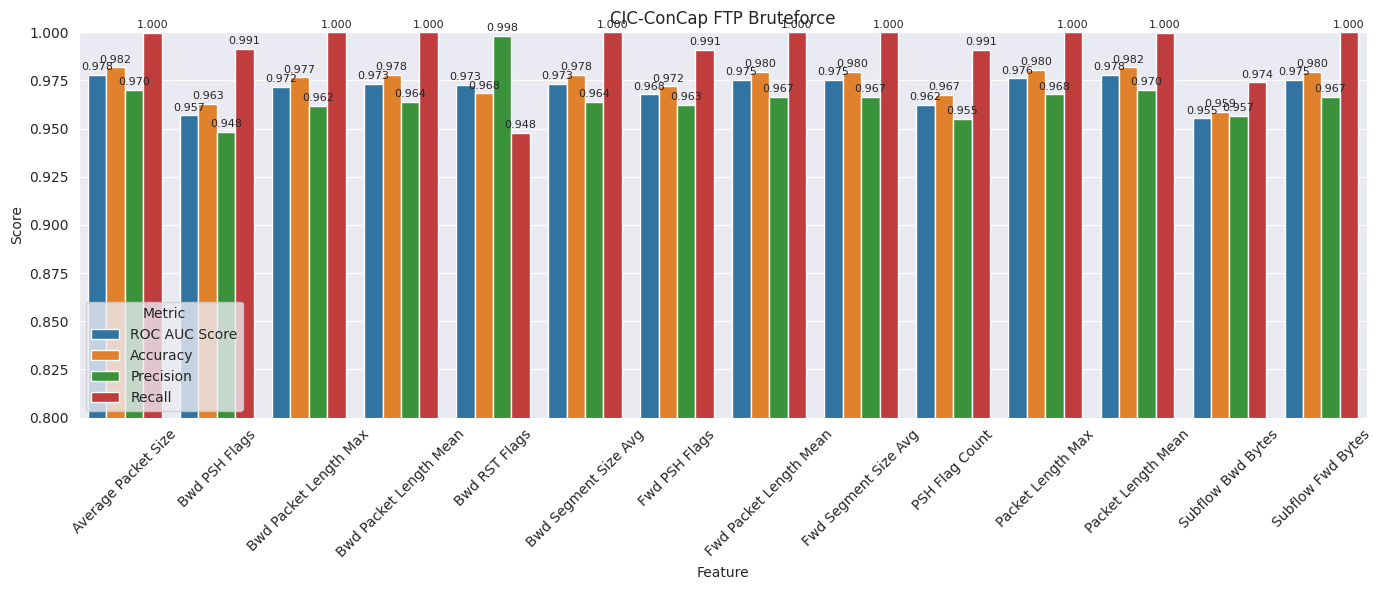

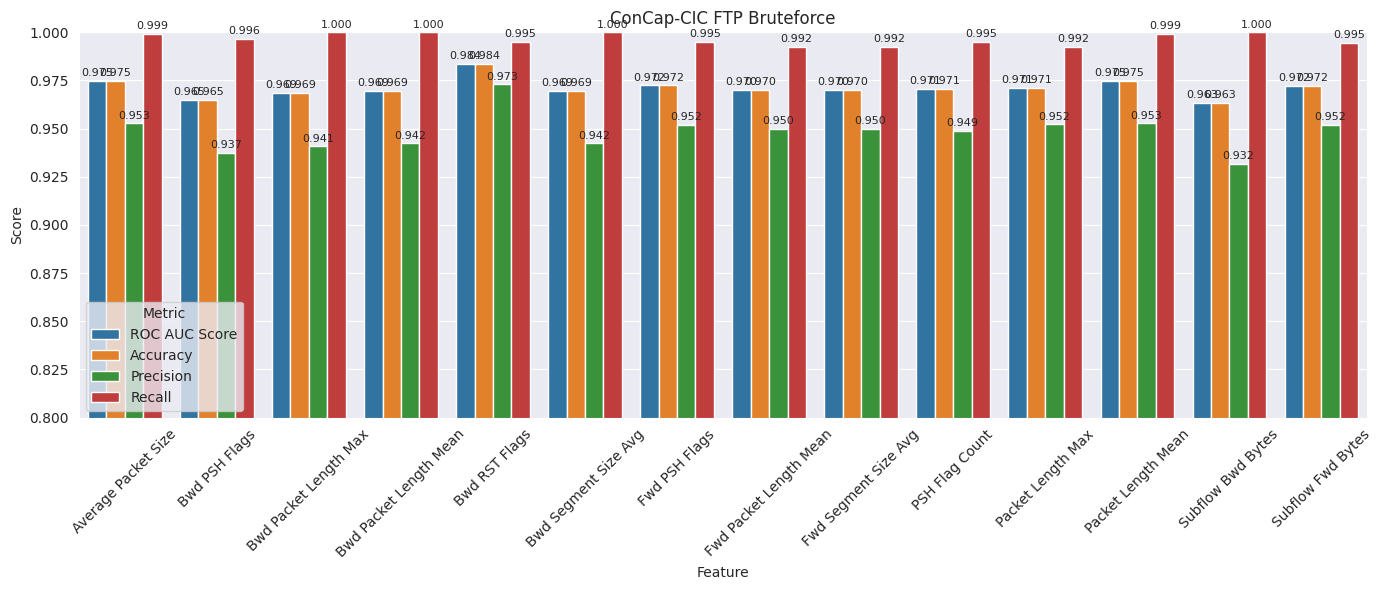

In [11]:
features = get_best_features(cic_concap, concap_cic, .95)
visualize(cic_concap, features, "CIC-ConCap FTP Bruteforce")
visualize(concap_cic, features, "ConCap-CIC FTP Bruteforce")

## SSH Bruteforce

In [12]:
cic_ssh = tuesday_cic[tuesday_cic["Label"] == "SSH-Patator"].copy()
cic_ssh["Label"] = 1
cic_ssh

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
79299,6,4755497,14,15,1304,2153,640,0,93.142860,174.584717,...,0,0,0.0,0.0,0,0,-1,-1,4755497,1
79300,6,4742052,14,15,1304,2153,640,0,93.142860,174.584717,...,0,0,0.0,0.0,0,0,-1,-1,4742052,1
79301,6,1688206,10,10,1128,2009,640,0,112.800003,203.802078,...,0,0,0.0,0.0,0,0,-1,-1,1688206,1
79302,6,1884425,13,11,1128,2009,640,0,86.769234,183.298553,...,0,0,0.0,0.0,0,0,-1,-1,1884425,1
79303,6,1937542,13,11,1128,2009,640,0,86.769234,183.298553,...,0,0,0.0,0.0,0,0,-1,-1,1937542,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321777,6,11725520,22,33,2024,2745,640,0,92.000000,138.338440,...,0,0,0.0,0.0,0,0,-1,-1,11725520,1
321784,6,11641016,22,33,2024,2745,640,0,92.000000,138.338440,...,0,0,0.0,0.0,0,0,-1,-1,11641016,1
321785,6,12117686,22,33,2008,2745,640,0,91.272728,138.182144,...,0,0,0.0,0.0,0,0,-1,-1,12117686,1
321944,6,13640748,22,33,2008,2745,640,0,91.272728,138.182144,...,0,0,0.0,0.0,0,0,-1,-1,13640748,1


In [13]:
concap_ssh = get_concap_dataset("concap_ssh.csv")
concap_ssh.drop(columns=["label", "category", "subcategory"], inplace=True, errors='ignore')
concap_ssh["Label"] = 1
concap_ssh

/tmp/ipykernel_16720/1145961106.py:33: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,4660,3,3,24.0,0.0,24.0,0.0,8.000000,13.856406,...,0,0,0,0,0,0,-1,-1,4660,1
1,6,3557,3,3,24.0,0.0,24.0,0.0,8.000000,13.856406,...,0,0,0,0,0,0,-1,-1,3557,1
2,6,19511,4,3,24.0,0.0,24.0,0.0,6.000000,12.000000,...,0,0,0,0,0,0,-1,-1,19511,1
3,6,11027649,22,34,1928.0,2746.0,640.0,0.0,87.636360,137.780548,...,0,0,0,0,0,0,-1,-1,11027649,1
4,6,9870,5,4,24.0,0.0,24.0,0.0,4.800000,10.733127,...,0,0,0,0,0,0,-1,-1,9870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7633,6,4487608,17,17,1272.0,2154.0,640.0,0.0,74.823532,161.218887,...,0,0,0,0,0,0,-1,-1,4487608,1
7634,6,3367832,14,16,1272.0,2154.0,640.0,0.0,90.857140,174.415451,...,0,0,0,0,0,0,-1,-1,3367832,1
7635,6,4025378,17,17,1272.0,2154.0,640.0,0.0,74.823532,161.218887,...,0,0,0,0,0,0,-1,-1,4025378,1
7636,6,3951,4,4,24.0,0.0,24.0,0.0,6.000000,12.000000,...,0,0,0,0,0,0,-1,-1,3951,1


In [14]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_ssh, concap_ssh)

Protocol
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWR Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd Bytes/Bulk Avg
Bwd Packet/Bulk Avg
Bwd Bulk Rate Avg
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
FWD Init Win Bytes
Bwd Init Win Bytes
Fwd Act Data Pkts
Fwd Seg Size Min
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Idle Std
Idle Max
Idle Min
ICMP Code
ICMP Type
Total TCP Flow Time


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Protocol
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWR Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd By

In [15]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.918853,0.954430,0.940959,0.999476
67,FWD Init Win Bytes,0.879939,0.932918,0.914840,1.000000
24,Fwd IAT Min,0.857466,0.856119,0.940481,0.854412
46,SYN Flag Count,0.801925,0.889329,0.866871,1.000000
12,Bwd Packet Length Mean,0.795779,0.839041,0.884097,0.893820
56,Bwd Segment Size Avg,0.795779,0.839041,0.884097,0.893820
7,Fwd Packet Length Min,0.782675,0.878573,0.855798,1.000000
40,Packet Length Min,0.781324,0.877819,0.855032,1.000000
0,Protocol,0.779973,0.877064,0.854267,1.000000
11,Bwd Packet Length Min,0.778960,0.876498,0.853694,1.000000


In [16]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.922492,0.922492,0.866218,0.999325
24,Fwd IAT Min,0.848362,0.848362,0.803829,0.921648
12,Bwd Packet Length Mean,0.836542,0.836542,0.759979,0.983789
56,Bwd Segment Size Avg,0.836542,0.836542,0.759979,0.983789
37,Bwd Header Length,0.813070,0.813070,0.727876,1.000000
45,FIN Flag Count,0.812226,0.812226,0.728103,0.996623
30,Fwd PSH Flags,0.809524,0.809524,0.724138,1.000000
9,Fwd Packet Length Std,0.809017,0.809017,0.723607,1.000000
46,SYN Flag Count,0.808848,0.808848,0.723539,0.999662
48,PSH Flag Count,0.807329,0.807329,0.721843,1.000000


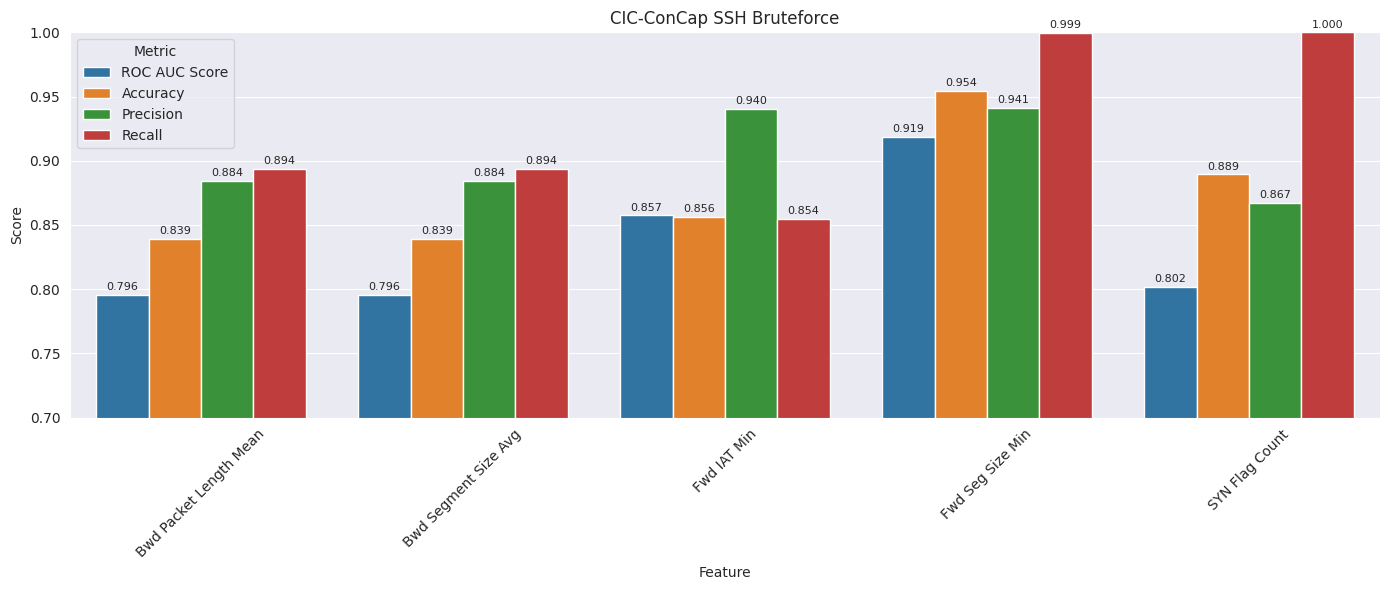

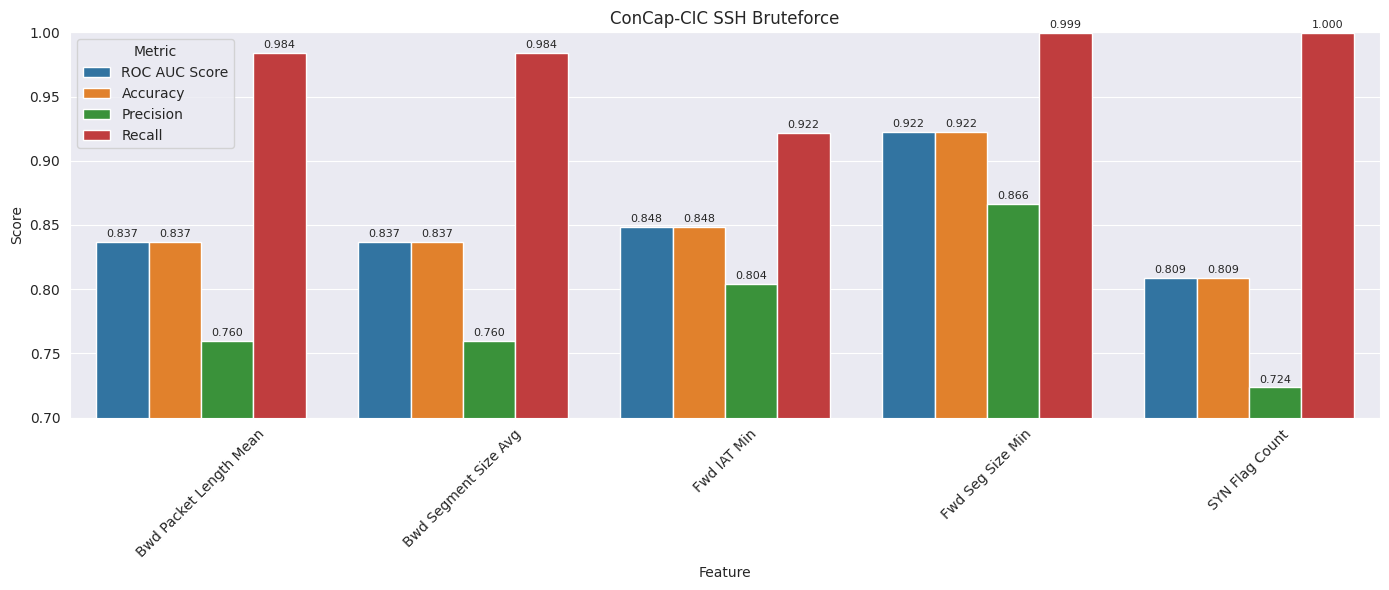

In [17]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap SSH Bruteforce", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC SSH Bruteforce", y_min=.7)

# Wednesday

In [4]:
wednesday_cic = get_cic_dataset("wednesday.csv")

/tmp/ipykernel_19459/4025526146.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [5]:
wednesday_cic["Label"].unique()

['BENIGN', 'DoS Slowloris', 'DoS Slowloris - Attempted', 'DoS Slowhttptest', 'DoS Slowhttptest - Attempted', 'DoS Hulk', 'DoS Hulk - Attempted', 'DoS GoldenEye', 'Heartbleed', 'DoS GoldenEye - Attempted']
Categories (10, object): ['BENIGN', 'DoS GoldenEye', 'DoS GoldenEye - Attempted', 'DoS Hulk', ..., 'DoS Slowhttptest - Attempted', 'DoS Slowloris', 'DoS Slowloris - Attempted', 'Heartbleed']

## Slowloris

In [20]:
cic_slowloris = wednesday_cic[wednesday_cic["Label"] == "DoS Slowloris"].copy()
cic_slowloris["Label"] = 1
cic_slowloris

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
9593,6,17072865,4,3,239,0,231,0,59.750000,114.228935,...,1415,1415,17071390.0,0.0,17071390,17071390,-1,-1,17072865,1
9594,6,17069963,4,3,239,0,231,0,59.750000,114.228935,...,856,856,17069048.0,0.0,17069049,17069049,-1,-1,17069963,1
9595,6,17071303,4,3,239,0,231,0,59.750000,114.228935,...,1002,1002,17070196.0,0.0,17070196,17070196,-1,-1,17071303,1
9596,6,17070583,4,3,239,0,231,0,59.750000,114.228935,...,740,740,17069780.0,0.0,17069779,17069779,-1,-1,17070583,1
9597,6,17069147,4,3,239,0,231,0,59.750000,114.228935,...,942,942,17068164.0,0.0,17068165,17068165,-1,-1,17069147,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31140,6,4603499,11,3,1155,483,231,0,105.000000,120.635818,...,0,0,0.0,0.0,0,0,-1,-1,4603499,1
31172,6,4204862,11,3,1386,483,231,0,126.000000,120.635818,...,0,0,0.0,0.0,0,0,-1,-1,4204862,1
31188,6,3202193,10,3,1386,483,231,0,138.600006,119.287888,...,0,0,0.0,0.0,0,0,-1,-1,3202193,1
31204,6,2599709,10,3,1155,483,231,0,115.500000,121.747688,...,0,0,0.0,0.0,0,0,-1,-1,2599709,1


In [21]:
concap_slowloris = get_concap_dataset("concap_slowloris.csv")
concap_slowloris

/tmp/ipykernel_16720/1145961106.py:33: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,118926264,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118926264,1
1,6,118849273,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118849273,1
2,6,118886942,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118886942,1
3,6,118823677,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118823677,1
4,6,118644621,62,61,725.0,0.0,253.0,0.0,11.693548,31.180904,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118644621,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,6,64981331,7,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,7124966.0,7124966.0,19285456.0,12963483.0,33536460.0,8193397.0,-1,-1,64981331,1
2116,6,108873650,60,59,685.0,406.0,253.0,0.0,11.416667,31.795050,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,108873650,1
2117,6,64054899,7,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,7221325.0,7221325.0,18944524.0,12403887.0,32514392.0,8190908.0,-1,-1,64054899,1
2118,6,107089854,59,58,677.0,406.0,253.0,0.0,11.474576,32.064781,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,107089854,1


In [22]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_slowloris, concap_slowloris)

Protocol
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWR Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd Bytes/Bulk Avg
Bwd Packet/Bulk Avg
Bwd Bulk Rate Avg
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
FWD Init Win Bytes
Bwd Init Win Bytes
Fwd Act Data Pkts
Fwd Seg Size Min
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Idle Std
Idle Max
Idle Min
ICMP Code
ICMP Type
Total TCP Flow Time
Protocol
Flow Duration
Total Fwd Packet


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWR Flag Count
ECE Flag Count
Down/Up Ratio


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Average Packet Size
Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd Bytes/Bulk Avg
Bwd Packet/Bulk Avg
Bwd Bulk Rate Avg
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
FWD Init Win Bytes
Bwd Init Win Bytes
Fwd Act Data Pkts
Fwd Seg Size Min
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Idle Std
Idle Max
Idle Min
ICMP Code
ICMP Type


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Total TCP Flow Time


In [23]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
54,Average Packet Size,0.941077,0.938618,0.885614,0.949528
42,Packet Length Mean,0.941077,0.938618,0.885614,0.949528
14,Flow Bytes/s,0.928379,0.922228,0.849009,0.949528
81,Total TCP Flow Time,0.909782,0.885600,0.758832,0.992925
24,Fwd IAT Min,0.899951,0.888276,0.786504,0.940094
4,Total Length of Fwd Packet,0.799350,0.846630,0.901804,0.636792
6,Fwd Packet Length Max,0.799350,0.846630,0.901804,0.636792
8,Fwd Packet Length Mean,0.797147,0.843787,0.891678,0.636792
55,Fwd Segment Size Avg,0.797147,0.843787,0.891678,0.636792
10,Bwd Packet Length Max,0.796111,0.842449,0.886991,0.636792


In [24]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
10,Bwd Packet Length Max,0.938196,0.938196,0.948541,0.926665
5,Total Length of Bwd Packet,0.938196,0.938196,0.948541,0.926665
12,Bwd Packet Length Mean,0.936382,0.936382,0.945032,0.926665
66,Subflow Bwd Bytes,0.936382,0.936382,0.945032,0.926665
56,Bwd Segment Size Avg,0.936382,0.936382,0.945032,0.926665
81,Total TCP Flow Time,0.906193,0.906193,0.877075,0.944804
75,Idle Mean,0.874320,0.874320,0.924728,0.814978
77,Idle Max,0.873413,0.873413,0.928359,0.809277
38,Fwd Packets/s,0.844260,0.844260,0.837097,0.854885
15,Flow Packets/s,0.839207,0.839207,0.827906,0.856439


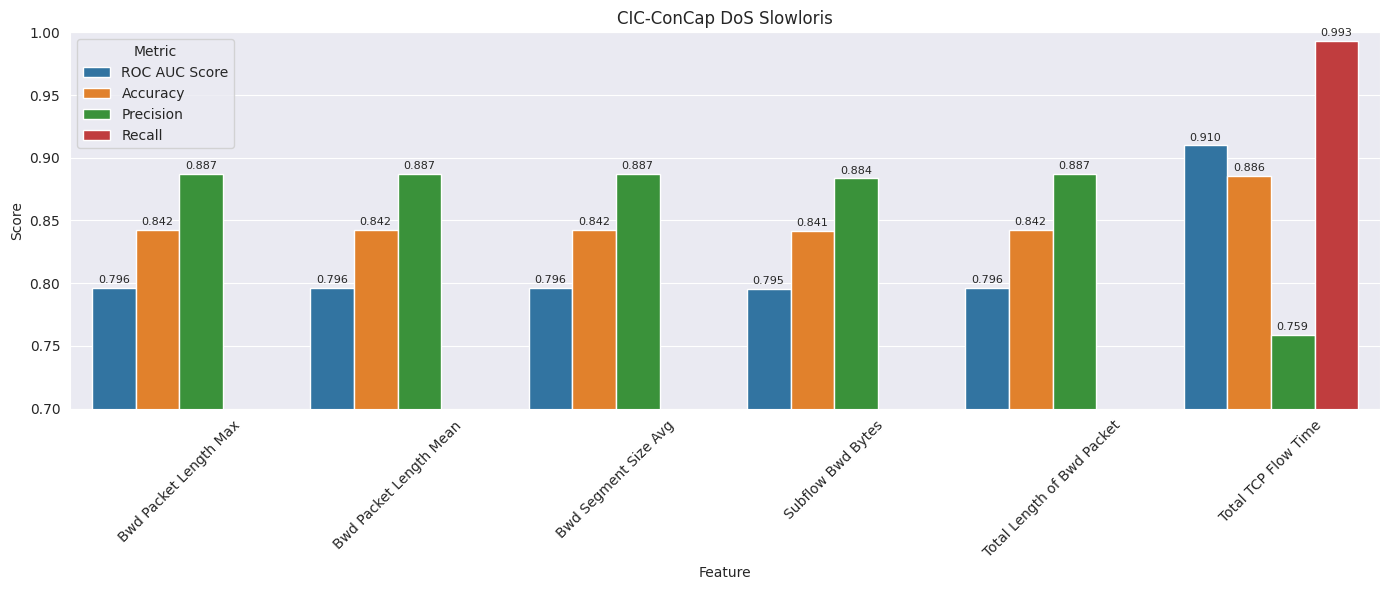

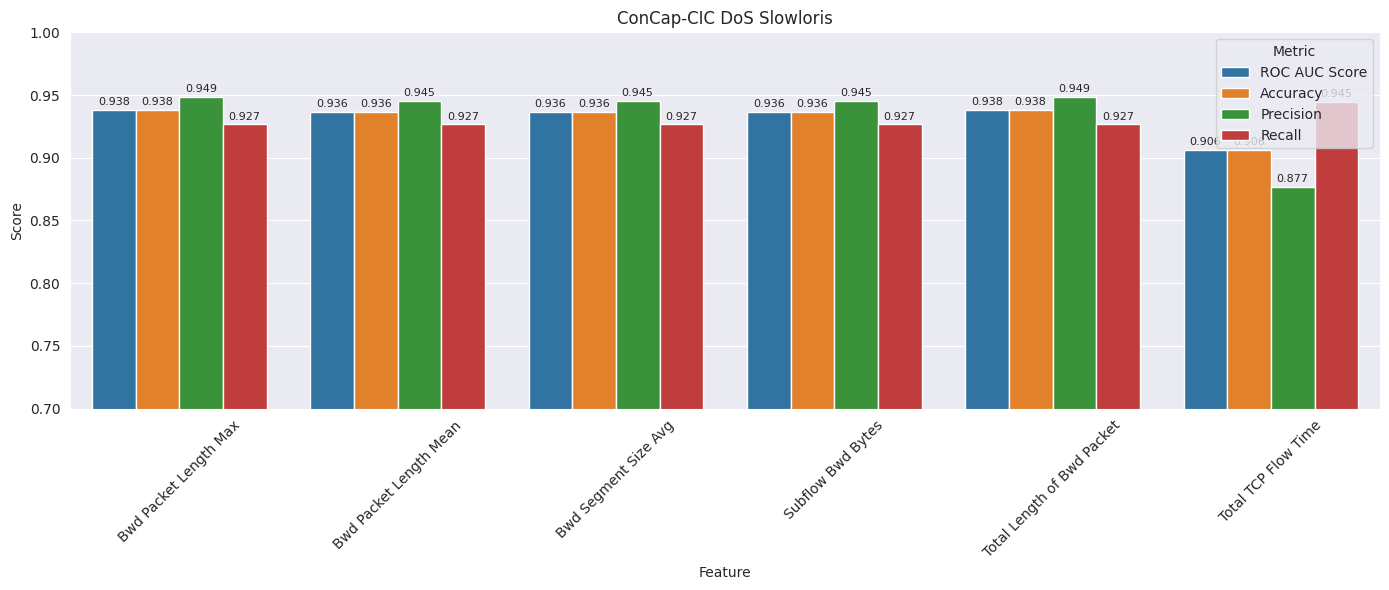

In [25]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap DoS Slowloris", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS Slowloris", y_min=.7)

## Slowhttptest

In [26]:
cic_slowhttptest = wednesday_cic[wednesday_cic["Label"] == "DoS Slowhttptest"].copy()
cic_slowhttptest["Label"] = 1
cic_slowhttptest

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
17978,6,83400021,18,2,5200,0,520,0,288.888885,265.881195,...,7008529,377,11641182.0,6049226.50,20776227,5399131,-1,-1,83400021,1
17979,6,83385834,18,2,5200,0,520,0,288.888885,265.881195,...,7010520,364,11638500.0,6086458.00,20840094,5303271,-1,-1,83385834,1
17995,6,83385227,18,2,5200,0,520,0,288.888885,265.881195,...,7010191,549,11638408.0,6086421.00,20839833,5303148,-1,-1,83385227,1
17996,6,83430584,18,2,5200,0,520,0,288.888885,265.881195,...,7015028,549,11645156.0,6050565.50,20776068,5399130,-1,-1,83430584,1
18004,6,83426649,18,2,5200,0,520,0,288.888885,265.881195,...,7011426,724,11645041.0,6050473.00,20775800,5399051,-1,-1,83426649,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330256,6,31589183,13,2,1683,0,187,0,129.461533,89.831894,...,6533504,6533504,8351745.0,4154461.25,13103822,5407489,-1,-1,31589183,1
360465,6,31521274,13,2,1683,0,187,0,129.461533,89.831894,...,6541345,6541345,8326464.5,4166748.75,13087961,5347461,-1,-1,31521274,1
392236,6,31405313,13,2,1683,0,187,0,129.461533,89.831894,...,6541322,6541322,8287807.0,4223231.00,13103684,5215656,-1,-1,31405313,1
434805,6,31389292,7,2,935,0,187,0,133.571426,91.246658,...,1629605,1629605,29759688.0,0.00,29759687,29759687,-1,-1,31389292,1


In [27]:
concap_slowhttptest = get_concap_dataset("concap_slowhttptest.csv")
concap_slowhttptest

/tmp/ipykernel_16720/1145961106.py:33: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,118697166,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118697166,1
1,6,118535863,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118535863,1
2,6,118513518,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118513518,1
3,6,118493155,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118493155,1
4,6,118374171,62,61,697.0,0.0,461.0,0.0,11.241936,58.060085,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118374171,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,6,1038645,4,3,4.0,406.0,4.0,0.0,1.000000,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,121389140,1
2110,6,118579235,64,62,697.0,406.0,461.0,0.0,10.890625,57.165070,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,118579235,1
2111,6,64665907,7,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,7069661.0,7069661.0,19198748.0,12824313.0,33279304.0,8187769.0,-1,-1,64665907,1
2112,6,113178113,63,61,689.0,406.0,461.0,0.0,10.936508,57.627522,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,113178113,1


In [28]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_slowhttptest, concap_slowhttptest)

Protocol
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWR Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd Bytes/Bulk Avg
Bwd Packet/Bulk Avg
Bwd Bulk Rate Avg
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
FWD Init Win Bytes
Bwd Init Win Bytes
Fwd Act Data Pkts
Fwd Seg Size Min
Active Mean
Active Std
Active Max
Active Min
Idle Mean
Idle Std
Idle Max
Idle Min
ICMP Code
ICMP Type
Total TCP Flow Time


/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Protocol
Flow Duration
Total Fwd Packet
Total Bwd packets
Total Length of Fwd Packet
Total Length of Bwd Packet
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Bytes/s
Flow Packets/s
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
Fwd RST Flags
Bwd RST Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Packet Length Min
Packet Length Max
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWR Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Fwd Segment Size Avg
Bwd Segment Size Avg
Fwd Bytes/Bulk Avg
Fwd Packet/Bulk Avg
Fwd Bulk Rate Avg
Bwd By

In [29]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
81,Total TCP Flow Time,0.916278,0.923696,0.882625,0.992901
24,Fwd IAT Min,0.904110,0.906566,0.902989,0.929484
14,Flow Bytes/s,0.895539,0.901116,0.877178,0.953147
20,Fwd IAT Total,0.884941,0.890994,0.866292,0.947468
1,Flow Duration,0.884941,0.890994,0.866292,0.947468
7,Fwd Packet Length Min,0.799138,0.818583,0.751422,1.000000
67,FWD Init Win Bytes,0.798665,0.818064,0.751246,0.999053
70,Fwd Seg Size Min,0.798665,0.818064,0.751246,0.999053
40,Packet Length Min,0.798563,0.818064,0.750888,1.000000
0,Protocol,0.797414,0.817026,0.749823,1.000000


In [30]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
38,Fwd Packets/s,0.895977,0.895977,0.852610,0.957471
15,Flow Packets/s,0.887931,0.887931,0.840565,0.957471
21,Fwd IAT Mean,0.885920,0.885920,0.840345,0.952874
81,Total TCP Flow Time,0.883333,0.883333,0.876836,0.891954
16,Flow IAT Mean,0.883046,0.883046,0.831427,0.960920
39,Bwd Packets/s,0.883046,0.883046,0.830114,0.963218
24,Fwd IAT Min,0.869253,0.869253,0.870317,0.867816
75,Idle Mean,0.860057,0.860057,0.913531,0.795402
22,Fwd IAT Std,0.841379,0.841379,0.773733,0.964943
5,Total Length of Bwd Packet,0.837644,0.837644,0.934863,0.725862


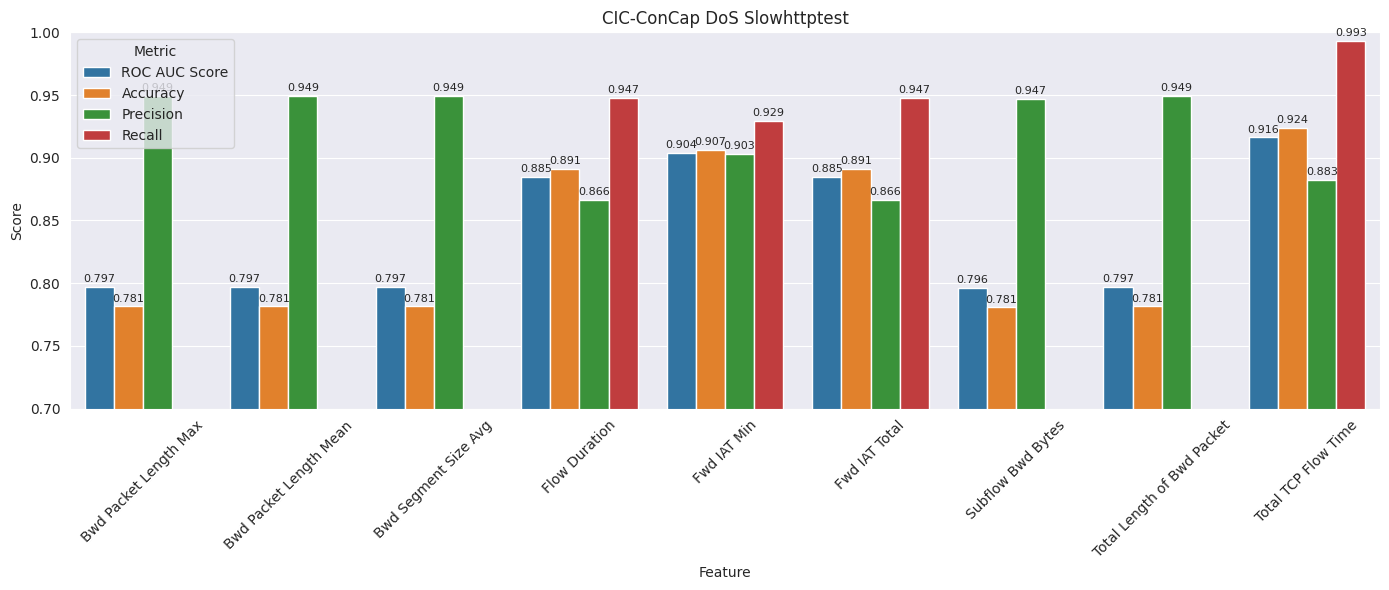

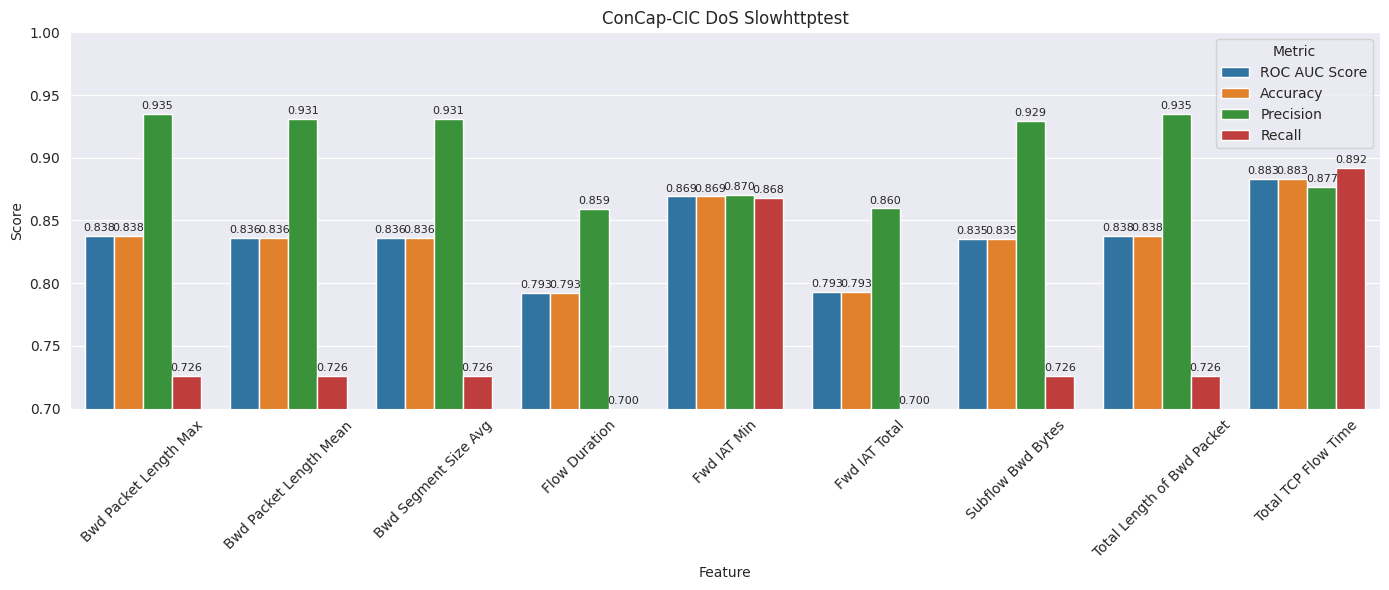

In [31]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap DoS Slowhttptest", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS Slowhttptest", y_min=.7)

## Hulk

In [5]:
cic_hulk = wednesday_cic[wednesday_cic["Label"] == "DoS Hulk"].copy()
cic_hulk["Label"] = 1
cic_hulk

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
33083,6,28504,9,9,348,11595,348,0,38.666668,116.000000,...,0,0,0.0,0.0,0,0,-1,-1,28504,1
33084,6,3466,6,6,382,11595,382,0,63.666668,155.950851,...,0,0,0.0,0.0,0,0,-1,-1,3466,1
33085,6,4212,6,6,372,11595,372,0,62.000000,151.868362,...,0,0,0.0,0.0,0,0,-1,-1,4212,1
33086,6,12080,7,7,349,11595,349,0,49.857143,131.909607,...,0,0,0.0,0.0,0,0,-1,-1,12080,1
33087,6,12005,6,5,371,11595,371,0,61.833332,151.460114,...,0,0,0.0,0.0,0,0,-1,-1,12005,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477866,6,173006,7,7,343,11595,343,0,49.000000,129.641815,...,0,0,0.0,0.0,0,0,-1,-1,173006,1
477873,6,179441,8,4,346,11595,346,0,43.250000,122.329475,...,0,0,0.0,0.0,0,0,-1,-1,179441,1
477903,6,189968,8,8,353,11595,353,0,44.125000,124.804344,...,0,0,0.0,0.0,0,0,-1,-1,189968,1
477909,6,656477,11,5,1041,11595,347,0,94.636360,162.083481,...,0,0,0.0,0.0,0,0,-1,-1,656477,1


In [6]:
concap_hulk = get_concap_dataset("concap_hulk.csv").astype(np.float64)
concap_hulk

/tmp/ipykernel_19459/4025526146.py:33: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6.0,3070.0,7.0,5.0,366.0,11611.0,366.0,0.0,52.285713,138.334991,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,3070.0,1.0
1,6.0,6535.0,7.0,5.0,336.0,11611.0,336.0,0.0,48.000000,126.996063,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,6535.0,1.0
2,6.0,7113.0,7.0,5.0,361.0,11611.0,361.0,0.0,51.571430,136.445175,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,7113.0,1.0
3,6.0,6639.0,7.0,6.0,317.0,11611.0,317.0,0.0,45.285713,119.814735,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,6639.0,1.0
4,6.0,7900.0,7.0,8.0,367.0,11611.0,367.0,0.0,52.428570,138.712967,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,7900.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172334,6.0,1529068.0,10.0,11.0,373.0,11611.0,373.0,0.0,37.299999,117.952957,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1529068.0,1.0
172335,6.0,309216.0,7.0,6.0,363.0,11611.0,363.0,0.0,51.857143,137.201111,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,309216.0,1.0
172336,6.0,378797.0,9.0,7.0,307.0,11611.0,307.0,0.0,34.111111,102.333336,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,378797.0,1.0
172337,6.0,521034.0,10.0,7.0,638.0,11611.0,319.0,0.0,63.799999,134.502213,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,521034.0,1.0


In [8]:
concap_hulk.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags',
       'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', '

In [8]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_hulk, concap_hulk)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [9]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,0.957175,0.955448,0.998343,0.916003
34,Fwd RST Flags,0.954777,0.956597,0.924527,0.998172
47,RST Flag Count,0.945467,0.947679,0.910046,0.998242
44,Packet Length Variance,0.941314,0.939031,0.995629,0.886863
43,Packet Length Std,0.941314,0.939031,0.995629,0.886863
66,Subflow Bwd Bytes,0.928231,0.926416,0.971247,0.884953
42,Packet Length Mean,0.926658,0.924965,0.966912,0.886300
54,Average Packet Size,0.926658,0.924965,0.966912,0.886300
5,Total Length of Bwd Packet,0.922579,0.921625,0.947087,0.899831
12,Bwd Packet Length Mean,0.911849,0.908711,0.985590,0.837007


In [10]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,0.999044,0.999044,0.998412,0.999678
12,Bwd Packet Length Mean,0.978866,0.978866,0.959592,0.999836
56,Bwd Segment Size Avg,0.978866,0.978866,0.959592,0.999836
10,Bwd Packet Length Max,0.976696,0.976696,0.955610,0.999836
66,Subflow Bwd Bytes,0.974146,0.974146,0.950975,0.999836
41,Packet Length Max,0.973335,0.973335,0.949511,0.999836
5,Total Length of Bwd Packet,0.972430,0.972430,0.947880,0.999836
42,Packet Length Mean,0.971269,0.971269,0.945798,0.999836
54,Average Packet Size,0.971269,0.971269,0.945798,0.999836
34,Fwd RST Flags,0.955666,0.955666,0.918685,0.999830


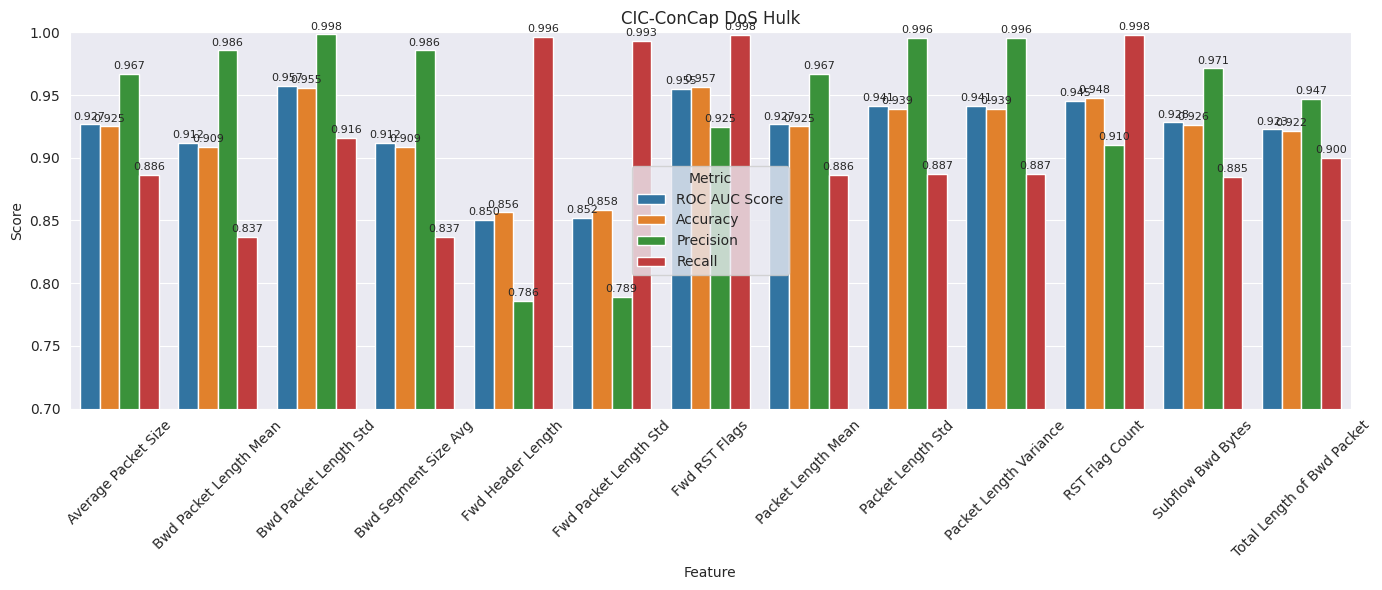

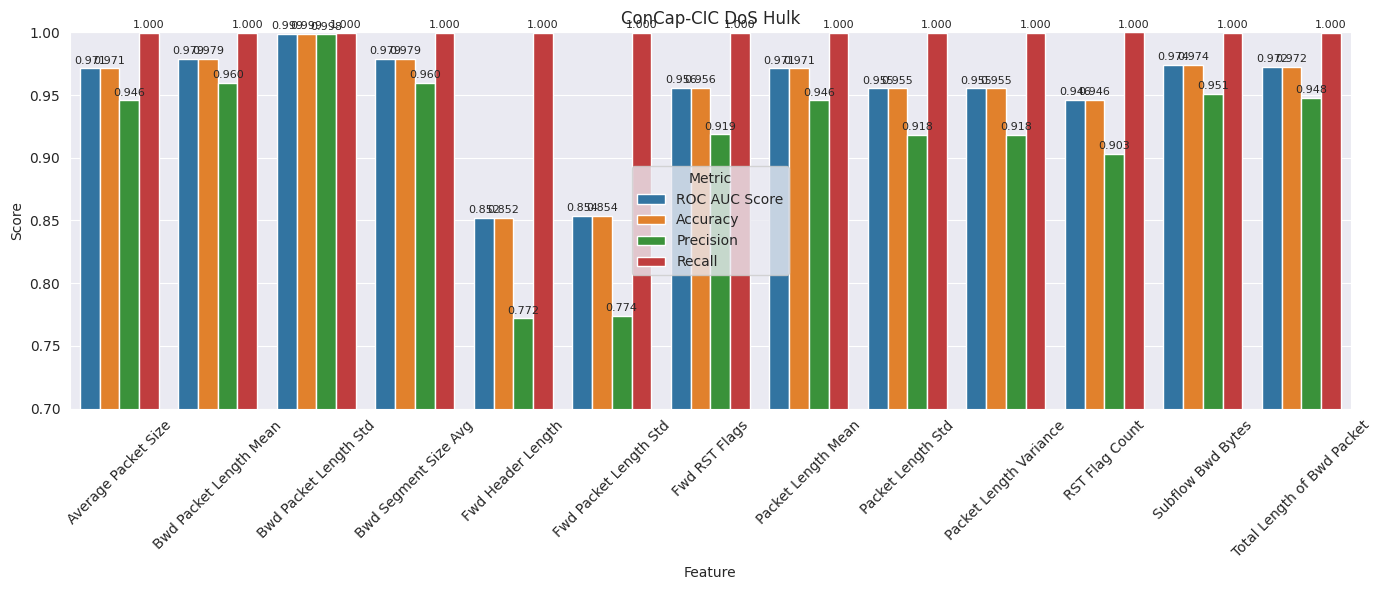

In [11]:
features = get_best_features(cic_concap, concap_cic, .85)
visualize(cic_concap, features, "CIC-ConCap DoS Hulk", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS Hulk", y_min=.7)

## GoldenEye

In [38]:
cic_goldeneye = wednesday_cic[wednesday_cic["Label"] == "DoS GoldenEye"].copy()
cic_goldeneye["Label"] = 1
cic_goldeneye

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
188941,6,11454901,9,4,1776,3525,444,0,197.333333,234.008547,...,827250,1474,5293676.0,4.105236e+05,5583960,5003392,-1,-1,11454901,1
188942,6,17437659,12,6,327,11632,327,0,27.250000,94.396769,...,7015689,7015689,5381199.0,0.000000e+00,5381199,5381199,-1,-1,17437659,1
188943,6,10753804,8,6,361,11632,361,0,45.125000,127.632774,...,4287,1108,5355279.5,5.017255e+05,5710053,5000506,-1,-1,10753804,1
188944,6,10752381,8,5,377,11632,377,0,47.125000,133.289628,...,1351,1351,5710766.0,0.000000e+00,5710766,5710766,-1,-1,10752381,1
188945,6,11422331,9,5,487,11632,487,0,54.111111,162.333333,...,1647,712,5690607.5,9.735835e+05,6379035,5002180,-1,-1,11422331,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496543,6,9726755,9,5,300,11632,300,0,33.333333,100.000000,...,4685619,4685619,5001471.0,0.000000e+00,5001471,5001471,-1,-1,201163062,1
496555,6,11509160,6,5,332,3525,332,0,55.333333,135.538432,...,1887,1887,6467018.0,0.000000e+00,6467018,6467018,-1,-1,11509160,1
496603,6,103680007,13,6,1472,11632,368,0,113.230769,176.781482,...,829021,3207,34269690.0,5.022459e+07,92263198,5000791,-1,-1,103680007,1
496606,6,11464350,9,5,588,11632,588,0,65.333333,196.000000,...,749,749,6423318.0,0.000000e+00,6423318,6423318,-1,-1,11464350,1


In [39]:
concap_goldeneye = get_concap_dataset("concap_goldeneye.csv")
concap_goldeneye

/tmp/ipykernel_10517/4060741420.py:32: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 3.59M/3.59M [00:01<00:00, 3.73MB/s]


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,13783803,10,11,1200.0,11610.0,300.0,0.0,120.000000,154.919334,...,853356.0,853356.0,1.289990e+07,0.000000e+00,12899901.0,12899901.0,-1,-1,13783803,1
1,6,56835564,9,6,500.0,11610.0,500.0,0.0,55.555556,166.666667,...,5046952.0,4878.0,2.589187e+07,1.734867e+07,38159227.0,13624507.0,-1,-1,56835564,1
2,6,25057619,9,7,404.0,11610.0,404.0,0.0,44.888889,134.666667,...,5047163.0,1704.0,1.000438e+07,7.025186e+06,14971933.0,5036819.0,-1,-1,25057619,1
3,6,38433193,10,6,512.0,11610.0,512.0,0.0,51.200000,161.908616,...,5045362.0,6431.0,1.669070e+07,4.830814e+06,20106601.0,13274799.0,-1,-1,38433193,1
4,6,5703764,9,8,328.0,11610.0,328.0,0.0,36.444444,109.333333,...,843.0,843.0,5.562874e+06,0.000000e+00,5562874.0,5562874.0,-1,-1,5703764,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4657,6,35282270,11,7,414.0,11610.0,414.0,0.0,37.636364,124.825697,...,1015225.0,1608.0,1.140679e+07,5.741702e+06,16095574.0,5003009.0,-1,-1,35282270,1
4658,6,75378643,8,6,509.0,11610.0,509.0,0.0,63.625000,179.958676,...,44432.0,2646.0,2.510878e+07,2.733661e+07,56235375.0,5002188.0,-1,-1,75378643,1
4659,6,97824485,15,12,2440.0,11610.0,610.0,0.0,162.666667,279.220002,...,5046710.0,854857.0,4.596146e+07,4.560548e+07,78209401.0,13713517.0,-1,-1,97824485,1
4660,6,88655311,9,6,363.0,11610.0,363.0,0.0,40.333333,121.000000,...,45612.0,3088.0,2.953409e+07,3.548058e+07,70216725.0,5001881.0,-1,-1,88655311,1


In [88]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_goldeneye, concap_goldeneye)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [89]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
12,Bwd Packet Length Mean,0.971149,0.964318,0.914471,0.999785
56,Bwd Segment Size Avg,0.971149,0.964318,0.914471,0.999785
66,Subflow Bwd Bytes,0.958240,0.948277,0.880394,1.000000
34,Fwd RST Flags,0.954738,0.943940,0.871651,1.000000
42,Packet Length Mean,0.952029,0.940584,0.865006,1.000000
54,Average Packet Size,0.952029,0.940584,0.865006,1.000000
47,RST Flag Count,0.945751,0.932810,0.849991,1.000000
13,Bwd Packet Length Std,0.917160,0.931500,0.958644,0.857051
5,Total Length of Bwd Packet,0.899167,0.875113,0.752994,1.000000
43,Packet Length Std,0.898659,0.908585,0.898175,0.857051


In [90]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,0.960288,0.960288,0.998711,0.921766
43,Packet Length Std,0.957315,0.957315,0.924237,0.996300
44,Packet Length Variance,0.957315,0.957315,0.924237,0.996300
70,Fwd Seg Size Min,0.920114,0.920114,0.863980,0.997225
81,Total TCP Flow Time,0.871151,0.871151,0.828518,0.936038
27,Bwd IAT Std,0.865402,0.865402,0.839764,0.903132
26,Bwd IAT Mean,0.864279,0.864279,0.826174,0.922691
20,Fwd IAT Total,0.862825,0.862825,0.817436,0.934320
1,Flow Duration,0.861504,0.861504,0.815550,0.934320
74,Active Min,0.859257,0.859257,0.797331,0.963394


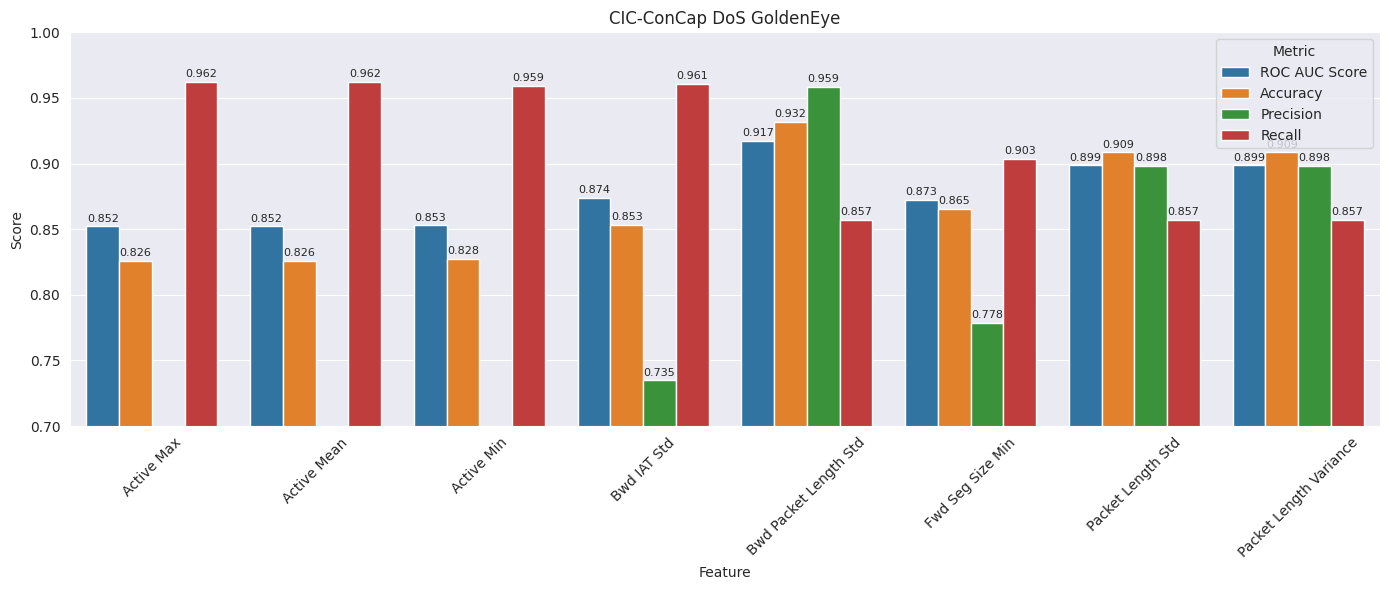

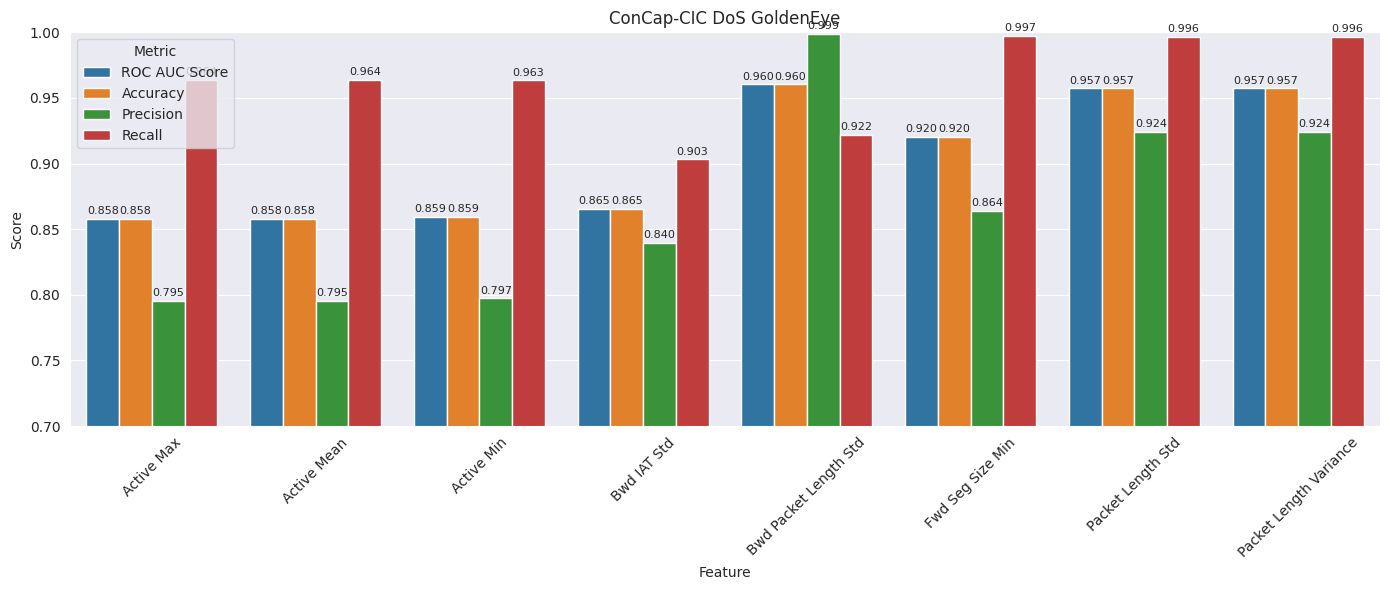

In [92]:
features = get_best_features(cic_concap, concap_cic, .85)
visualize(cic_concap, features, "CIC-ConCap DoS GoldenEye", y_min=.7)
visualize(concap_cic, features, "ConCap-CIC DoS GoldenEye", y_min=.7)

## Heartbleed

In [44]:
cic_heartbleed = wednesday_cic[wednesday_cic["Label"] == "Heartbleed"].copy()
cic_heartbleed["Label"] = 1
cic_heartbleed

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
244352,6,119302728,2685,1729,8299,7556917,517,0,3.090875,16.858421,...,2217,2217,5024984.0,0.0,5024984,5024984,-1,-1,119302728,1
245206,6,119262215,2791,2111,7920,7883927,66,0,2.837693,13.390275,...,0,0,0.0,0.0,0,0,-1,-1,239559056,1
246401,6,119261118,2793,2131,7920,7883880,66,0,2.835661,13.385693,...,0,0,0.0,0.0,0,0,-1,-1,359814372,1
247344,6,119260295,2790,2115,7920,7883880,66,0,2.838710,13.392567,...,0,0,0.0,0.0,0,0,-1,-1,480068718,1
248442,6,119297996,2781,2090,7920,7883880,66,0,2.847896,13.413253,...,0,0,0.0,0.0,0,0,-1,-1,600361033,1
248766,6,119259886,2781,2092,7920,7883880,66,0,2.847896,13.413253,...,0,0,0.0,0.0,0,0,-1,-1,720578677,1
249515,6,119259012,2800,2070,7920,7883880,66,0,2.828571,13.369695,...,0,0,0.0,0.0,0,0,-1,-1,840832907,1
249897,6,119257653,2801,2068,15066,7818181,1486,0,5.378793,62.757991,...,0,0,0.0,0.0,0,0,-1,-1,961085290,1
250774,6,119299621,2804,2029,7920,7884419,66,0,2.824536,13.360578,...,0,0,0.0,0.0,0,0,-1,-1,1081380819,1
251109,6,119296592,2796,2007,7920,7883880,66,0,2.832618,13.378830,...,0,0,0.0,0.0,0,0,-1,-1,1201633329,1


In [45]:
concap_heartbleed = get_concap_dataset("concap_heartbleed.csv")
concap_heartbleed

/tmp/ipykernel_10517/4060741420.py:32: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 83.3k/83.3k [00:00<00:00, 377kB/s]


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,17099,7,8,815.0,7759.0,517.0,0.0,116.428571,190.551705,...,0,0,0,0,0,0,-1,-1,17099,1
1,6,1014038,16,12,709.0,67223.0,517.0,0.0,44.312500,130.665843,...,0,0,0,0,0,0,-1,-1,1014038,1
2,6,1012724,16,12,709.0,67223.0,517.0,0.0,44.312500,130.665843,...,0,0,0,0,0,0,-1,-1,1012724,1
3,6,15288,8,9,815.0,7759.0,517.0,0.0,101.875000,181.155369,...,0,0,0,0,0,0,-1,-1,15288,1
4,6,1012355,20,13,709.0,67223.0,517.0,0.0,35.450000,117.515273,...,0,0,0,0,0,0,-1,-1,1012355,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,6,1014955,19,13,709.0,67223.0,517.0,0.0,37.315789,120.430733,...,0,0,0,0,0,0,-1,-1,1014955,1
110,6,1014035,20,13,709.0,67223.0,517.0,0.0,35.450000,117.515273,...,0,0,0,0,0,0,-1,-1,1014035,1
111,6,1010372,15,13,709.0,67223.0,517.0,0.0,47.266667,134.697792,...,0,0,0,0,0,0,-1,-1,1010372,1
112,6,12340,8,9,815.0,7759.0,517.0,0.0,101.875000,181.155369,...,0,0,0,0,0,0,-1,-1,12340,1


In [46]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_heartbleed, concap_heartbleed)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [47]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
13,Bwd Packet Length Std,1.000000,1.000,1.000000,1.000000
43,Packet Length Std,0.982456,0.968,1.000000,0.964912
14,Flow Bytes/s,0.954545,0.992,0.991304,1.000000
16,Flow IAT Mean,0.863636,0.976,0.974359,1.000000
6,Fwd Packet Length Max,0.818182,0.968,0.966102,1.000000
9,Fwd Packet Length Std,0.818182,0.968,0.966102,1.000000
7,Fwd Packet Length Min,0.772727,0.960,0.957983,1.000000
11,Bwd Packet Length Min,0.772727,0.960,0.957983,1.000000
77,Idle Max,0.772727,0.960,0.957983,1.000000
0,Protocol,0.772727,0.960,0.957983,1.000000


In [48]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
10,Bwd Packet Length Max,1.000000,1.000000,1.000000,1.0
13,Bwd Packet Length Std,1.000000,1.000000,1.000000,1.0
44,Packet Length Variance,1.000000,1.000000,1.000000,1.0
41,Packet Length Max,1.000000,1.000000,1.000000,1.0
43,Packet Length Std,1.000000,1.000000,1.000000,1.0
5,Total Length of Bwd Packet,0.954545,0.954545,0.916667,1.0
42,Packet Length Mean,0.954545,0.954545,0.916667,1.0
12,Bwd Packet Length Mean,0.954545,0.954545,0.916667,1.0
66,Subflow Bwd Bytes,0.954545,0.954545,0.916667,1.0
54,Average Packet Size,0.954545,0.954545,0.916667,1.0


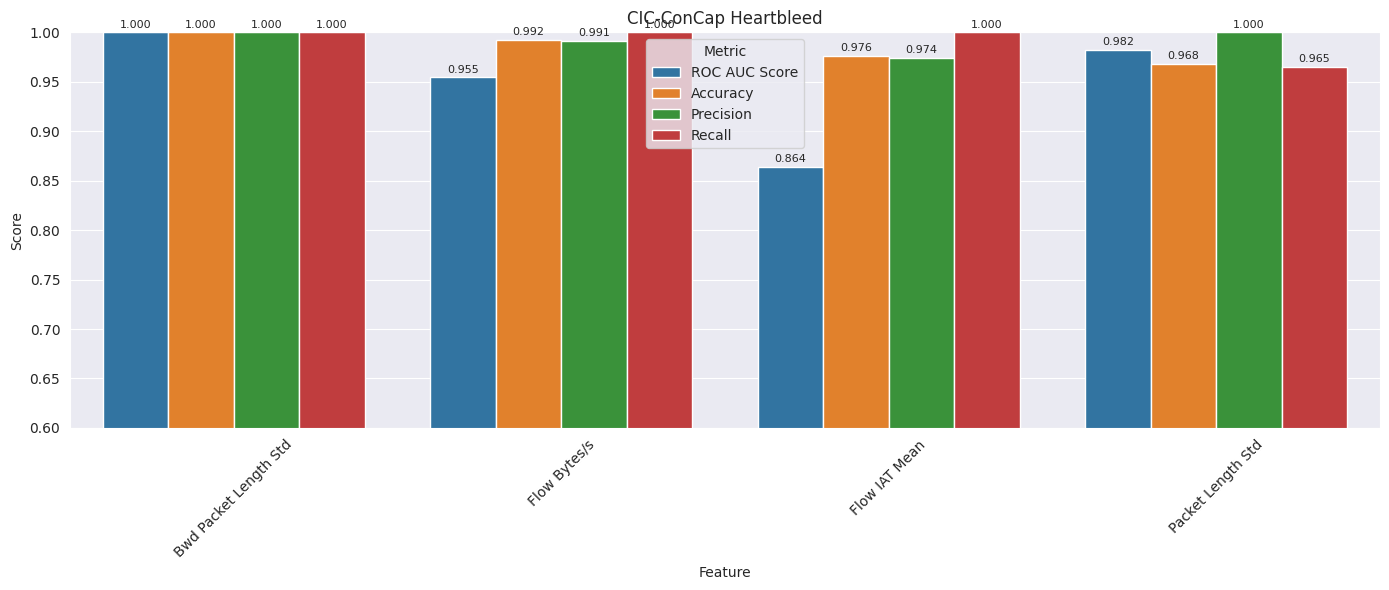

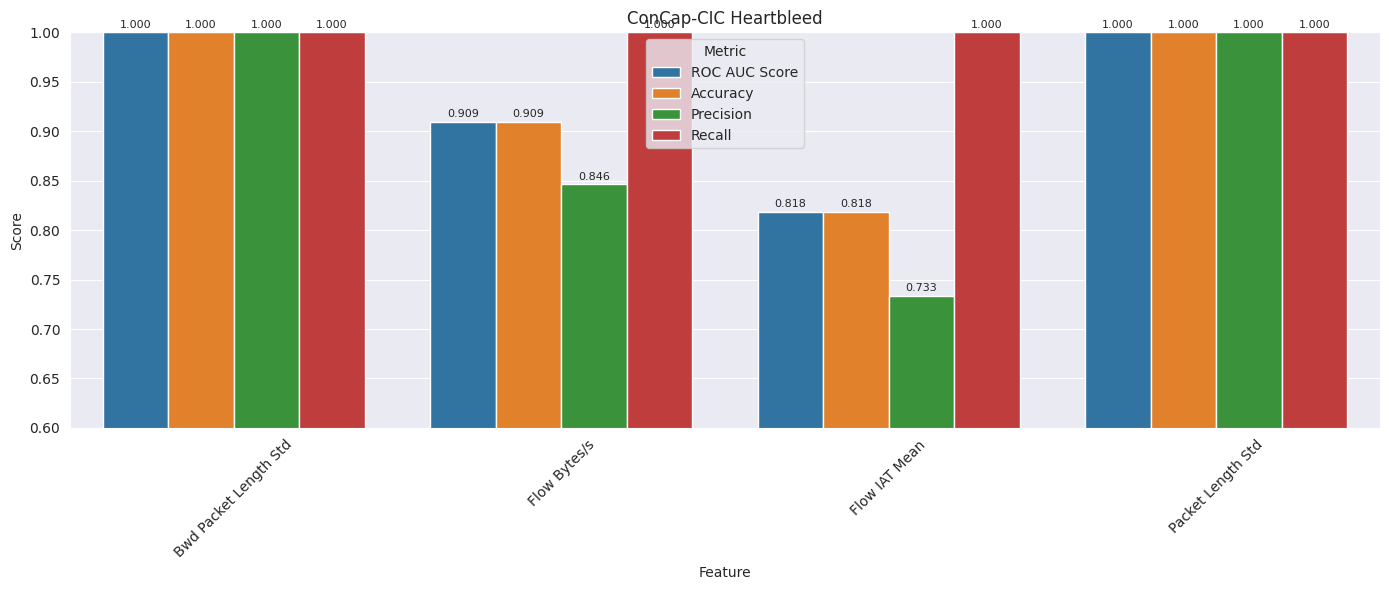

In [49]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap Heartbleed", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Heartbleed", y_min=.6)

# Thursday

In [50]:
thursday_cic = get_cic_dataset("thursday.csv")
thursday_cic["Label"].unique()

/tmp/ipykernel_10517/4060741420.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 181M/181M [00:25<00:00, 7.44MB/s] 


array(['BENIGN', 'Web Attack - Brute Force - Attempted',
       'Web Attack - Brute Force', 'Infiltration - Attempted',
       'Infiltration', 'Infiltration - Portscan',
       'Web Attack - XSS - Attempted', 'Web Attack - XSS',
       'Web Attack - SQL Injection - Attempted',
       'Web Attack - SQL Injection'], dtype=object)

In [51]:
thursday_cic[thursday_cic["Label"] == "Web Attack - XSS"]

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
111769,6,60170367,208,107,47903,183657,585,0,230.302885,248.360420,...,0,0,0.0,0.0,0,0,-1,-1,60170367,Web Attack - XSS
117429,6,69374569,206,105,48783,183572,585,0,236.810680,252.210265,...,0,0,0.0,0.0,0,0,-1,-1,69374569,Web Attack - XSS
122100,6,69422816,206,110,48783,183586,585,0,236.810680,252.210265,...,0,0,0.0,0.0,0,0,-1,-1,69422816,Web Attack - XSS
123890,6,67553643,205,105,48985,183689,585,0,238.951220,253.242691,...,0,0,0.0,0.0,0,0,-1,-1,67553643,Web Attack - XSS
135899,6,68116521,205,105,48985,183692,585,0,238.951220,253.242691,...,0,0,0.0,0.0,0,0,-1,-1,68116521,Web Attack - XSS
143598,6,66976121,205,106,48783,183586,585,0,237.965854,252.280780,...,0,0,0.0,0.0,0,0,-1,-1,66976121,Web Attack - XSS
157591,6,68151611,205,115,48783,183606,585,0,237.965854,252.280780,...,0,0,0.0,0.0,0,0,-1,-1,68151611,Web Attack - XSS
158229,6,68065237,214,107,48783,183584,585,0,227.957944,251.492415,...,0,0,0.0,0.0,0,0,-1,-1,68065237,Web Attack - XSS
175342,6,67291468,210,105,48985,183697,585,0,233.261905,252.845913,...,0,0,0.0,0.0,0,0,-1,-1,67291468,Web Attack - XSS
177980,6,67053821,206,105,48985,183687,585,0,237.791262,253.172264,...,0,0,0.0,0.0,0,0,-1,-1,67053821,Web Attack - XSS


## Web Attack - Bruteforce

In [52]:
cic_bruteforce = thursday_cic[thursday_cic["Label"] == "Web Attack - Brute Force"].copy()
cic_bruteforce["Label"] = 1
cic_bruteforce

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
23550,6,35253111,204,105,43906,72181,602,0,215.225490,228.432176,...,0,0,0.0,0.0,0,0,-1,-1,35253111,1
115400,6,32925619,204,105,43951,72198,602,0,215.446078,228.590459,...,0,0,0.0,0.0,0,0,-1,-1,32925619,1
121724,6,33028450,204,105,43951,72194,602,0,215.446078,228.590459,...,0,0,0.0,0.0,0,0,-1,-1,33028450,1
121829,6,33347965,204,105,43951,72202,602,0,215.446078,228.590459,...,0,0,0.0,0.0,0,0,-1,-1,33347965,1
132222,6,34212507,204,105,43951,72194,602,0,215.446078,228.590459,...,0,0,0.0,0.0,0,0,-1,-1,34212507,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348864,6,34000093,204,105,43906,72186,602,0,215.225490,228.432176,...,0,0,0.0,0.0,0,0,-1,-1,34000093,1
355070,6,34282481,204,107,43951,72189,602,0,215.446078,228.590459,...,0,0,0.0,0.0,0,0,-1,-1,34282481,1
358600,6,34048558,204,105,43906,72188,602,0,215.225490,228.432176,...,0,0,0.0,0.0,0,0,-1,-1,34048558,1
358656,6,33954481,204,105,43906,72180,602,0,215.225490,228.432176,...,0,0,0.0,0.0,0,0,-1,-1,33954481,1


In [53]:
concap_bruteforce = get_concap_dataset("concap_web_bruteforce.csv")
concap_bruteforce

/tmp/ipykernel_10517/4060741420.py:32: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 20.2k/20.2k [00:00<00:00, 1.65MB/s]


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,936259,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,936259,1
1,6,1053085,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1053085,1
2,6,1029193,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1029193,1
3,6,1013865,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1013865,1
4,6,1071168,17,11,3094.0,14735.0,638.0,0.0,182.000000,231.709139,...,0,0,0,0,0,0,-1,-1,1071168,1
5,6,1011581,4,2,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,-1,-1,1011581,1
6,6,1270632,18,11,3095.0,14739.0,639.0,0.0,171.944444,228.967368,...,0,0,0,0,0,0,-1,-1,1270632,1
7,6,1266643,17,11,3094.0,14736.0,638.0,0.0,182.000000,231.709139,...,0,0,0,0,0,0,-1,-1,1266643,1
8,6,1338306,17,12,3093.0,14737.0,637.0,0.0,181.941176,231.586234,...,0,0,0,0,0,0,-1,-1,1338306,1
9,6,1135702,17,12,3092.0,14735.0,636.0,0.0,181.882353,231.463518,...,0,0,0,0,0,0,-1,-1,1135702,1


In [54]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_bruteforce, concap_bruteforce)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [55]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
70,Fwd Seg Size Min,0.938356,0.912621,0.769231,1.0
67,FWD Init Win Bytes,0.890411,0.844660,0.652174,1.0
24,Fwd IAT Min,0.865753,0.893204,0.827586,0.8
46,SYN Flag Count,0.856164,0.796117,0.588235,1.0
45,FIN Flag Count,0.842466,0.776699,0.566038,1.0
11,Bwd Packet Length Min,0.821918,0.747573,0.535714,1.0
7,Fwd Packet Length Min,0.815068,0.737864,0.526316,1.0
0,Protocol,0.815068,0.737864,0.526316,1.0
40,Packet Length Min,0.815068,0.737864,0.526316,1.0
8,Fwd Packet Length Mean,0.736301,0.834951,0.882353,0.5


In [56]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
8,Fwd Packet Length Mean,0.993151,0.993151,0.986486,1.000000
64,Subflow Fwd Bytes,0.993151,0.993151,0.986486,1.000000
55,Fwd Segment Size Avg,0.993151,0.993151,0.986486,1.000000
53,Down/Up Ratio,0.979452,0.979452,0.960526,1.000000
31,Bwd PSH Flags,0.958904,0.958904,0.924051,1.000000
48,PSH Flag Count,0.958904,0.958904,0.924051,1.000000
9,Fwd Packet Length Std,0.958904,0.958904,0.924051,1.000000
30,Fwd PSH Flags,0.952055,0.952055,0.912500,1.000000
24,Fwd IAT Min,0.945205,0.945205,0.922078,0.972603
69,Fwd Act Data Pkts,0.938356,0.938356,0.890244,1.000000


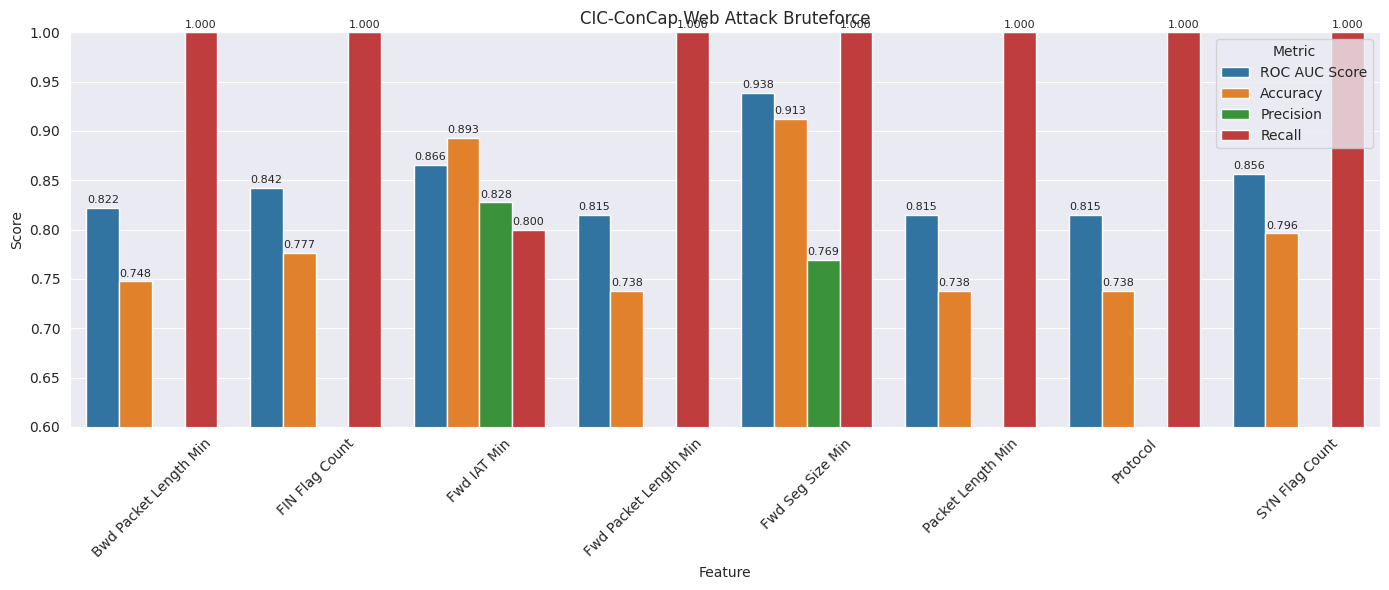

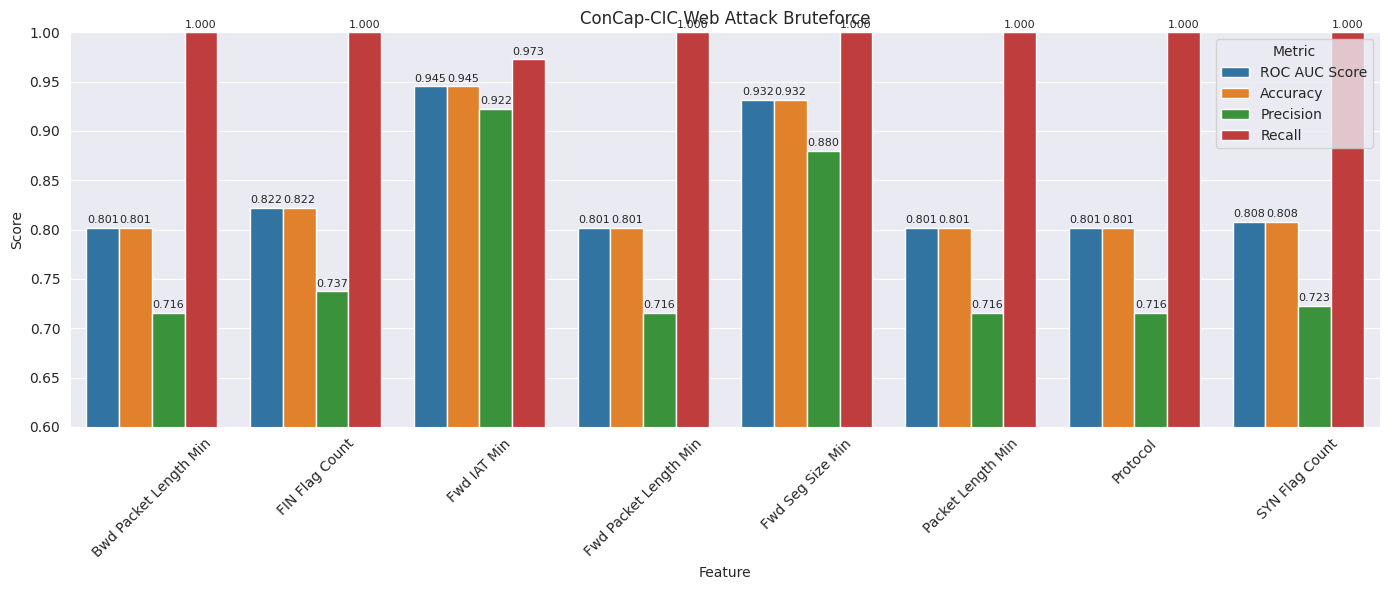

In [57]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap Web Attack Bruteforce", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Web Attack Bruteforce", y_min=.6)

## Web Attack - SQL Injection

In [58]:
cic_sqli = thursday_cic[thursday_cic["Label"] == "Web Attack - SQL Injection"].copy()
cic_sqli["Label"] = 1
cic_sqli

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
128107,6,5039303,5,5,537,1881,537,0,107.400000,240.153701,...,34275,34275,5004343.0,0.0,5004343,5004343,-1,-1,5039303,1
132409,6,5013185,7,5,600,4149,600,0,85.714286,226.778684,...,12319,12319,5000160.0,0.0,5000160,5000160,-1,-1,5013185,1
170331,6,5006123,6,4,599,2021,599,0,99.833333,244.540726,...,5243,5243,5000145.0,0.0,5000145,5000145,-1,-1,5006123,1
178931,6,5087203,6,5,600,4149,600,0,100.000000,244.948974,...,82611,82611,5003905.0,0.0,5003905,5003905,-1,-1,5087203,1
222113,6,5017466,6,6,599,4149,599,0,99.833333,244.540726,...,12710,12710,5004049.0,0.0,5004049,5004049,-1,-1,5017466,1
237434,6,5009656,5,5,599,2021,599,0,119.800000,267.880944,...,5358,5358,5003805.0,0.0,5003805,5003805,-1,-1,5009656,1
237572,6,5006730,5,5,599,2021,599,0,119.800000,267.880944,...,6119,6119,5000049.0,0.0,5000049,5000049,-1,-1,5006730,1
239282,6,5006912,6,5,447,530,447,0,74.500000,182.486986,...,5712,5712,5000415.0,0.0,5000415,5000415,-1,-1,5006912,1
286051,6,5009699,5,5,523,530,523,0,104.600000,233.892710,...,4355,4355,5004686.0,0.0,5004686,5004686,-1,-1,5009699,1
319013,6,5008202,6,4,537,1881,537,0,89.500000,219.229332,...,6787,6787,5000673.0,0.0,5000673,5000673,-1,-1,5008202,1


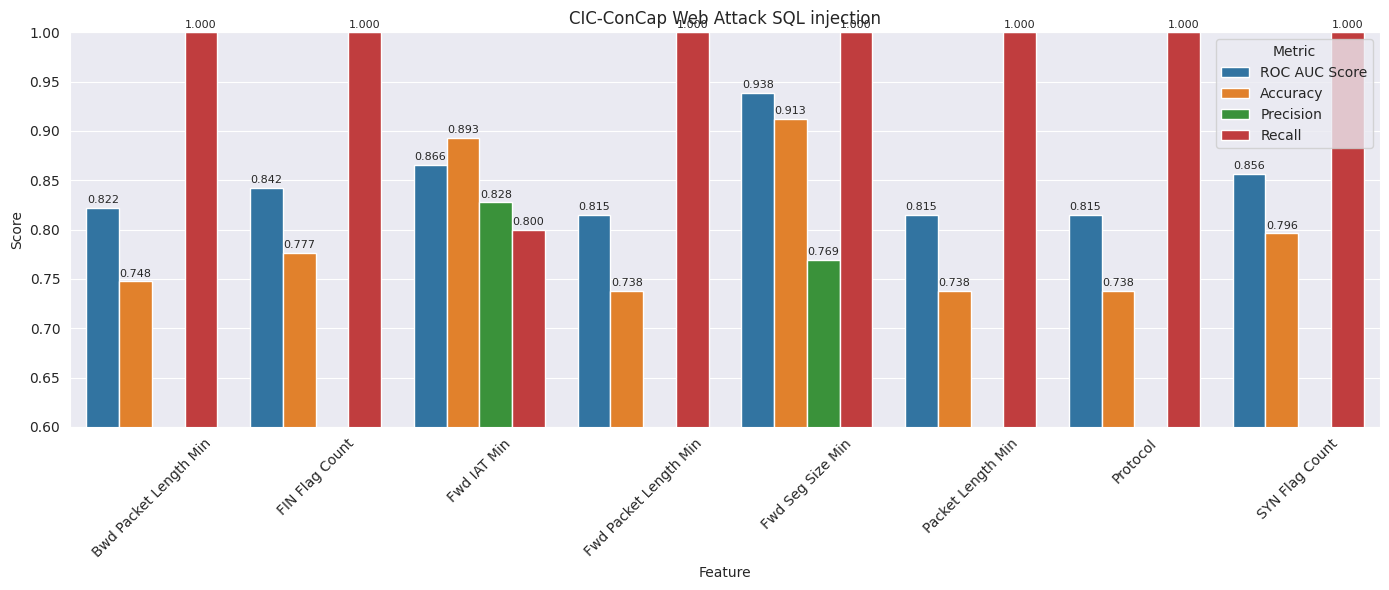

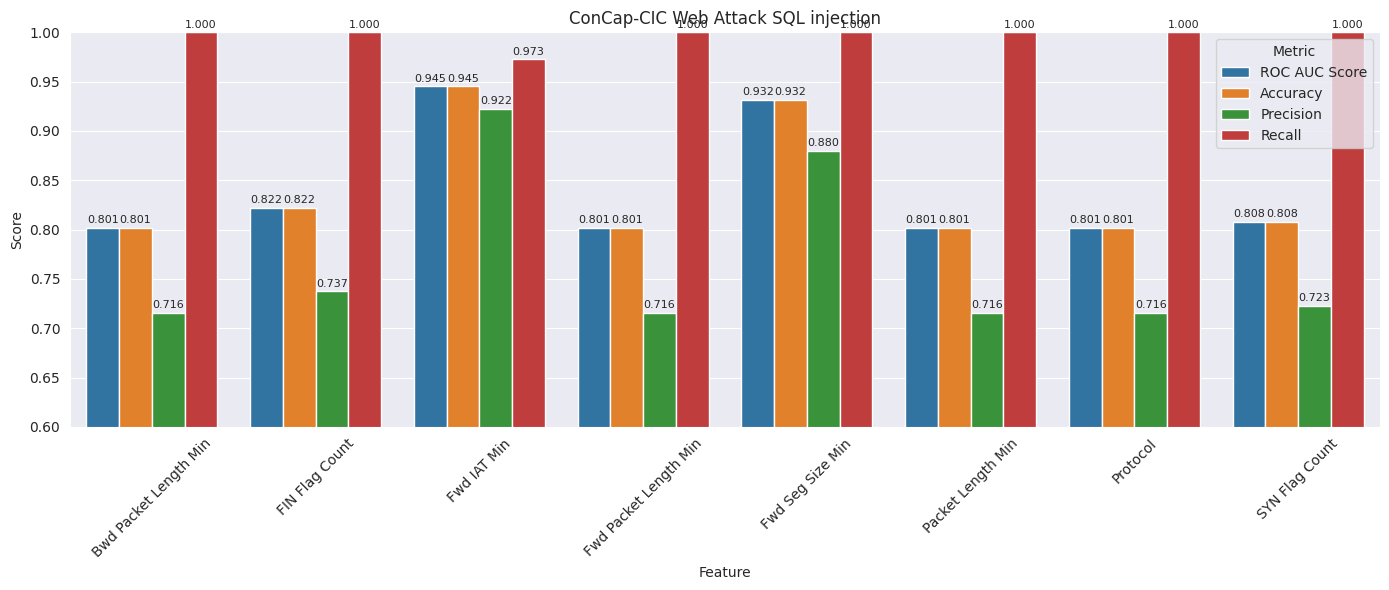

In [59]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap Web Attack SQL injection", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Web Attack SQL injection", y_min=.6)

## Web Attack - Cross-Site Scripting

In [60]:
cic_xss = thursday_cic[thursday_cic["Label"] == "Web Attack - XSS"].copy()
cic_xss["Label"] = 1
cic_xss

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
111769,6,60170367,208,107,47903,183657,585,0,230.302885,248.360420,...,0,0,0.0,0.0,0,0,-1,-1,60170367,1
117429,6,69374569,206,105,48783,183572,585,0,236.810680,252.210265,...,0,0,0.0,0.0,0,0,-1,-1,69374569,1
122100,6,69422816,206,110,48783,183586,585,0,236.810680,252.210265,...,0,0,0.0,0.0,0,0,-1,-1,69422816,1
123890,6,67553643,205,105,48985,183689,585,0,238.951220,253.242691,...,0,0,0.0,0.0,0,0,-1,-1,67553643,1
135899,6,68116521,205,105,48985,183692,585,0,238.951220,253.242691,...,0,0,0.0,0.0,0,0,-1,-1,68116521,1
143598,6,66976121,205,106,48783,183586,585,0,237.965854,252.280780,...,0,0,0.0,0.0,0,0,-1,-1,66976121,1
157591,6,68151611,205,115,48783,183606,585,0,237.965854,252.280780,...,0,0,0.0,0.0,0,0,-1,-1,68151611,1
158229,6,68065237,214,107,48783,183584,585,0,227.957944,251.492415,...,0,0,0.0,0.0,0,0,-1,-1,68065237,1
175342,6,67291468,210,105,48985,183697,585,0,233.261905,252.845913,...,0,0,0.0,0.0,0,0,-1,-1,67291468,1
177980,6,67053821,206,105,48985,183687,585,0,237.791262,253.172264,...,0,0,0.0,0.0,0,0,-1,-1,67053821,1


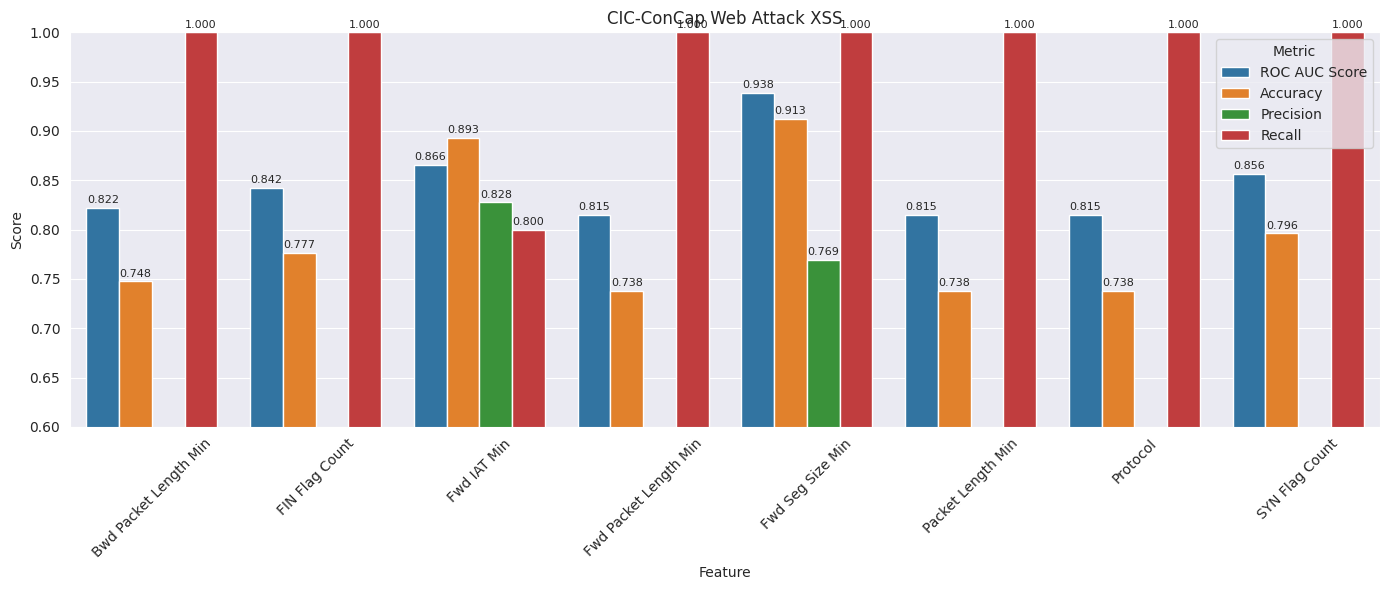

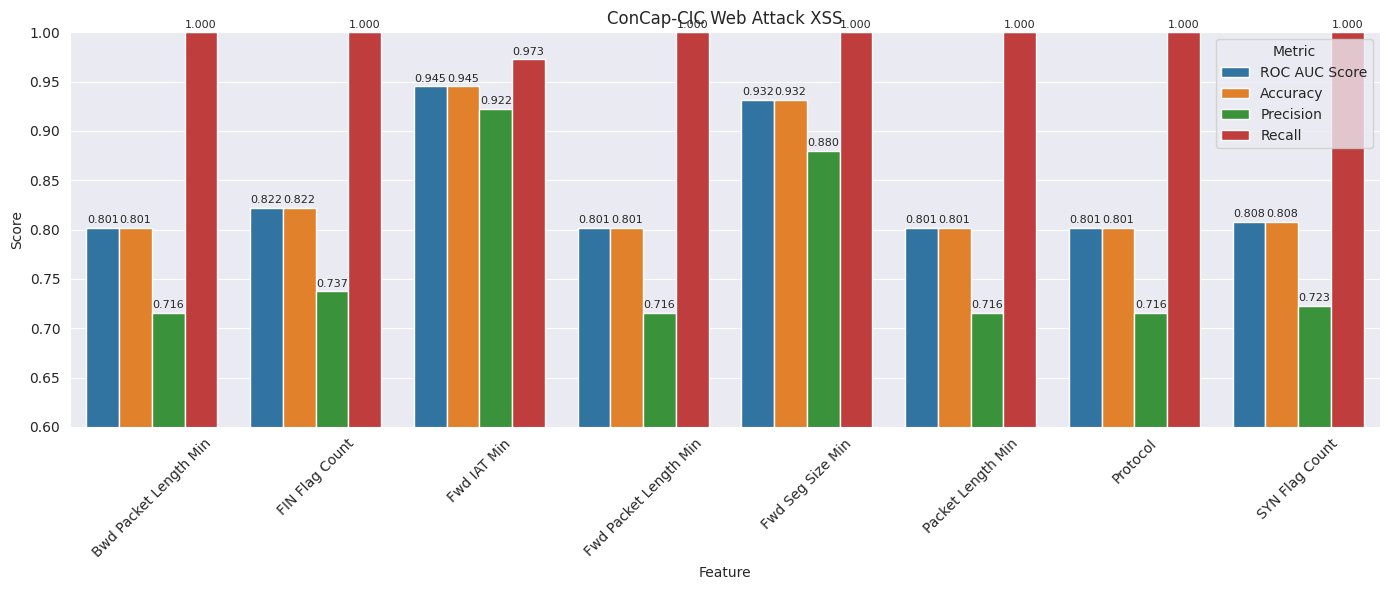

In [61]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap Web Attack XSS", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Web Attack XSS", y_min=.6)

# Friday

In [62]:
friday_cic = get_cic_dataset("friday.csv")

/tmp/ipykernel_10517/4060741420.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 272M/272M [00:35<00:00, 7.94MB/s] 


In [63]:
friday_cic["Label"].unique()

array(['BENIGN', 'Botnet - Attempted', 'Botnet', 'Portscan', 'DDoS'],
      dtype=object)

## LOIC

In [64]:
cic_loic = friday_cic[friday_cic["Label"] == "DDoS"].copy()
cic_loic["Label"] = 1
cic_loic

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
87193,6,9157589,8,6,20,11595,20,0,2.500000,7.071068,...,1084925,1084925,8072664.0,0.0,8072664,8072664,-1,-1,9157589,1
87194,6,6150288,8,6,20,11595,20,0,2.500000,7.071068,...,407765,407765,5742523.0,0.0,5742523,5742523,-1,-1,6150288,1
87195,6,8410717,8,6,20,11595,20,0,2.500000,7.071068,...,644213,644213,7766504.0,0.0,7766504,7766504,-1,-1,8410717,1
87198,6,7757913,8,5,20,11595,20,0,2.500000,7.071068,...,683993,683993,7073920.0,0.0,7073920,7073920,-1,-1,7757913,1
87199,6,8063397,8,6,20,11595,20,0,2.500000,7.071068,...,307905,307905,7755492.0,0.0,7755492,7755492,-1,-1,8063397,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547499,6,8809229,8,5,20,11595,20,0,2.500000,7.071068,...,708296,708296,8100933.0,0.0,8100933,8100933,-1,-1,8809229,1
547515,6,5746903,8,4,20,11595,20,0,2.500000,7.071068,...,0,0,0.0,0.0,0,0,-1,-1,5746903,1
547545,6,3966857,8,4,20,11595,20,0,2.500000,7.071068,...,0,0,0.0,0.0,0,0,-1,-1,3966857,1
547546,6,11276716,9,5,20,11595,20,0,2.222222,6.666667,...,113023,113023,11163693.0,0.0,11163693,11163693,-1,-1,11276716,1


In [65]:
concap_loic = get_concap_dataset("concap_loic.csv")
concap_loic.drop(columns=["target", "port", "service"], inplace=True, errors='ignore')
concap_loic

/tmp/ipykernel_10517/4060741420.py:32: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 22.4M/22.4M [00:03<00:00, 6.51MB/s]


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,31064,11,9,131.0,11574.0,131.0,0.0,11.909091,39.497986,...,0,0,0,0,0,0,-1,-1,31064,1
1,6,21147,10,8,131.0,11574.0,131.0,0.0,13.100000,41.425837,...,0,0,0,0,0,0,-1,-1,21147,1
2,6,20759,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639432,...,0,0,0,0,0,0,-1,-1,20759,1
3,6,21115,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639432,...,0,0,0,0,0,0,-1,-1,21115,1
4,6,20847,10,8,131.0,11574.0,131.0,0.0,13.100000,41.425837,...,0,0,0,0,0,0,-1,-1,20847,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33876,6,21435,10,8,132.0,11574.0,132.0,0.0,13.200000,41.742065,...,0,0,0,0,0,0,-1,-1,21435,1
33877,6,21625,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639432,...,0,0,0,0,0,0,-1,-1,21625,1
33878,6,21474,10,8,131.0,11574.0,131.0,0.0,13.100000,41.425837,...,0,0,0,0,0,0,-1,-1,21474,1
33879,6,22083,10,8,138.0,11574.0,138.0,0.0,13.800000,43.639432,...,0,0,0,0,0,0,-1,-1,22083,1


In [66]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_bruteforce, concap_bruteforce)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [67]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
68,Bwd Init Win Bytes,0.924658,0.893204,0.731707,1.0
70,Fwd Seg Size Min,0.910959,0.873786,0.697674,1.0
24,Fwd IAT Min,0.845205,0.864078,0.750000,0.8
67,FWD Init Win Bytes,0.842466,0.776699,0.566038,1.0
46,SYN Flag Count,0.760274,0.660194,0.461538,1.0
45,FIN Flag Count,0.760274,0.660194,0.461538,1.0
7,Fwd Packet Length Min,0.719178,0.601942,0.422535,1.0
40,Packet Length Min,0.719178,0.601942,0.422535,1.0
5,Total Length of Bwd Packet,0.715753,0.805825,0.750000,0.5
11,Bwd Packet Length Min,0.712329,0.592233,0.416667,1.0


In [68]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
31,Bwd PSH Flags,0.993151,0.993151,0.986486,1.000000
30,Fwd PSH Flags,0.993151,0.993151,0.986486,1.000000
48,PSH Flag Count,0.993151,0.993151,0.986486,1.000000
8,Fwd Packet Length Mean,0.979452,0.979452,0.960526,1.000000
4,Total Length of Fwd Packet,0.979452,0.979452,0.960526,1.000000
64,Subflow Fwd Bytes,0.979452,0.979452,0.960526,1.000000
55,Fwd Segment Size Avg,0.979452,0.979452,0.960526,1.000000
5,Total Length of Bwd Packet,0.979452,0.979452,0.960526,1.000000
69,Fwd Act Data Pkts,0.965753,0.965753,0.935897,1.000000
9,Fwd Packet Length Std,0.952055,0.952055,0.923077,0.986301


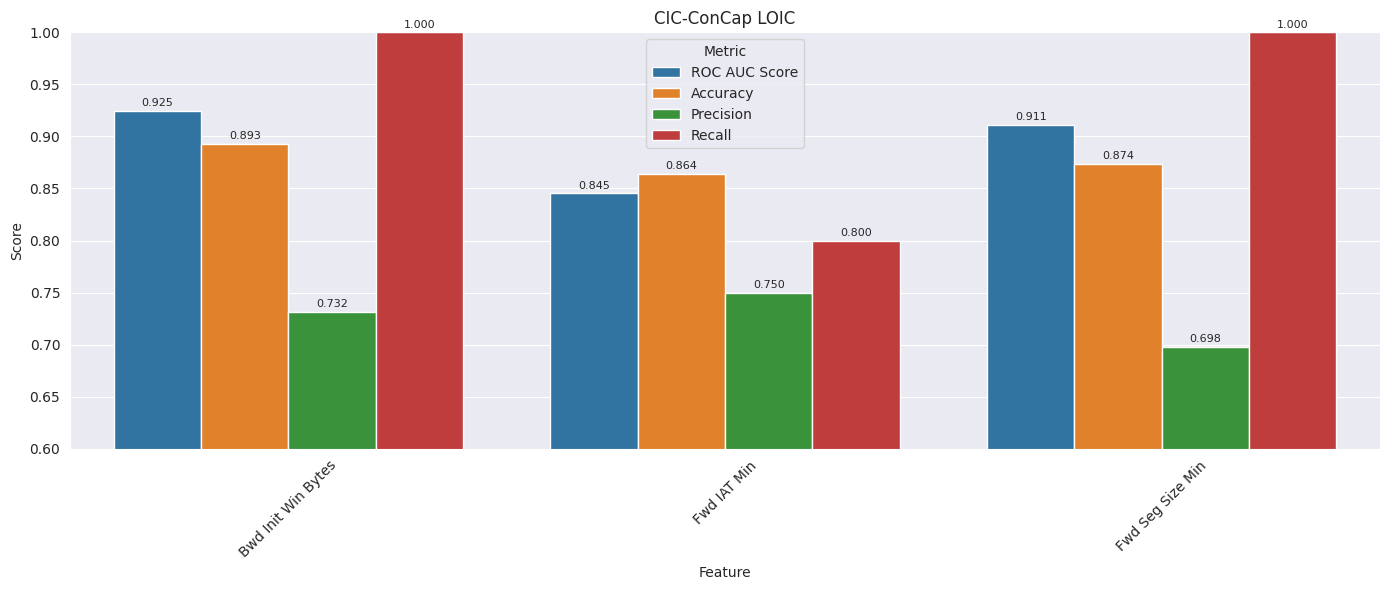

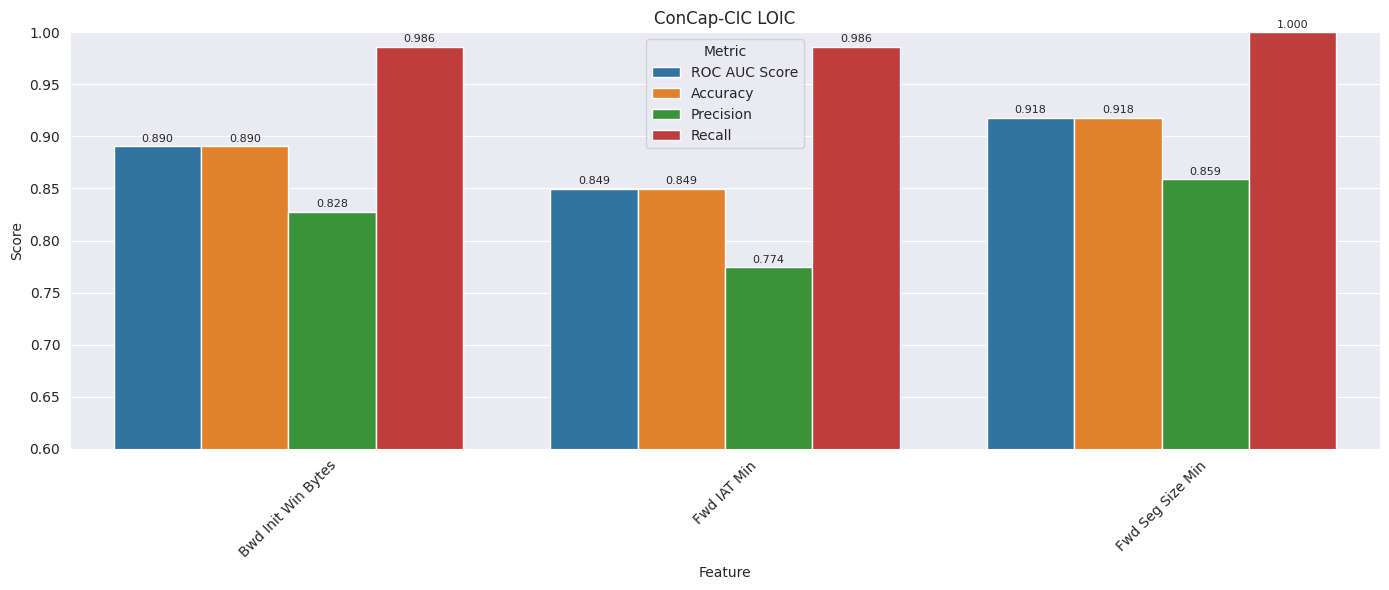

In [69]:
features = get_best_features(cic_concap, concap_cic, .79)
visualize(cic_concap, features, "CIC-ConCap LOIC", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC LOIC", y_min=.6)

## Portscan

In [77]:
cic_portscan = friday_cic[friday_cic["Label"] == "Portscan"].copy()
cic_portscan["Label"] = 1
cic_portscan

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
69627,6,44,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,44,1
69628,6,43,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,43,1
69629,6,54,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,54,1
69630,6,33,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,33,1
69632,6,50,1,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544589,6,662,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,662,1
544997,6,635,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,635,1
545175,6,691,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,691,1
545575,6,607,2,1,0,0,0,0,0.0,0.0,...,0,0,0.0,0.0,0,0,-1,-1,607,1


In [78]:
concap_portscan = get_concap_dataset("concap_portscan.csv")
concap_portscan

/tmp/ipykernel_10517/4060741420.py:32: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,6,52,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,52,1
1,6,12,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,12,1
2,6,13,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,13,1
3,6,74,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,74,1
4,6,30,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005,6,197,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,197,1
7028,6,132,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1,132,1
7205,1,111,2,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,8,0,1
7211,1,683,2,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,8,0,1


In [79]:
cic_concap, concap_cic = concap_cic_experiment(benign, cic_portscan, concap_portscan)

/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/messik/School/AJ24-25/Thesis/code/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [80]:
cic_concap.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
5,Total Length of Bwd Packet,0.962053,0.956674,0.875934,0.973422
12,Bwd Packet Length Mean,0.961756,0.956236,0.874627,0.973422
56,Bwd Segment Size Avg,0.961756,0.956236,0.874627,0.973422
10,Bwd Packet Length Max,0.959379,0.952735,0.864307,0.973422
66,Subflow Bwd Bytes,0.957596,0.950109,0.856725,0.973422
43,Packet Length Std,0.947454,0.946171,0.860150,0.950166
44,Packet Length Variance,0.947454,0.946171,0.860150,0.950166
41,Packet Length Max,0.945799,0.949234,0.877329,0.938538
6,Fwd Packet Length Max,0.939161,0.949672,0.894652,0.916944
4,Total Length of Fwd Packet,0.937500,0.948796,0.894309,0.913621


In [81]:
concap_cic.sort_values("ROC AUC Score", ascending=False).head(10)

,Feature,ROC AUC Score,Accuracy,Precision,Recall
6,Fwd Packet Length Max,0.957813,0.957813,0.955109,0.960784
8,Fwd Packet Length Mean,0.957516,0.957516,0.954545,0.960784
55,Fwd Segment Size Avg,0.957516,0.957516,0.954545,0.960784
64,Subflow Fwd Bytes,0.956922,0.956922,0.953420,0.960784
4,Total Length of Fwd Packet,0.938800,0.938800,0.959552,0.916221
41,Packet Length Max,0.937017,0.937017,0.945488,0.927510
5,Total Length of Bwd Packet,0.934938,0.934938,0.941496,0.927510
56,Bwd Segment Size Avg,0.928699,0.928699,0.941825,0.913844
12,Bwd Packet Length Mean,0.928699,0.928699,0.941825,0.913844
66,Subflow Bwd Bytes,0.927213,0.927213,0.943280,0.909091


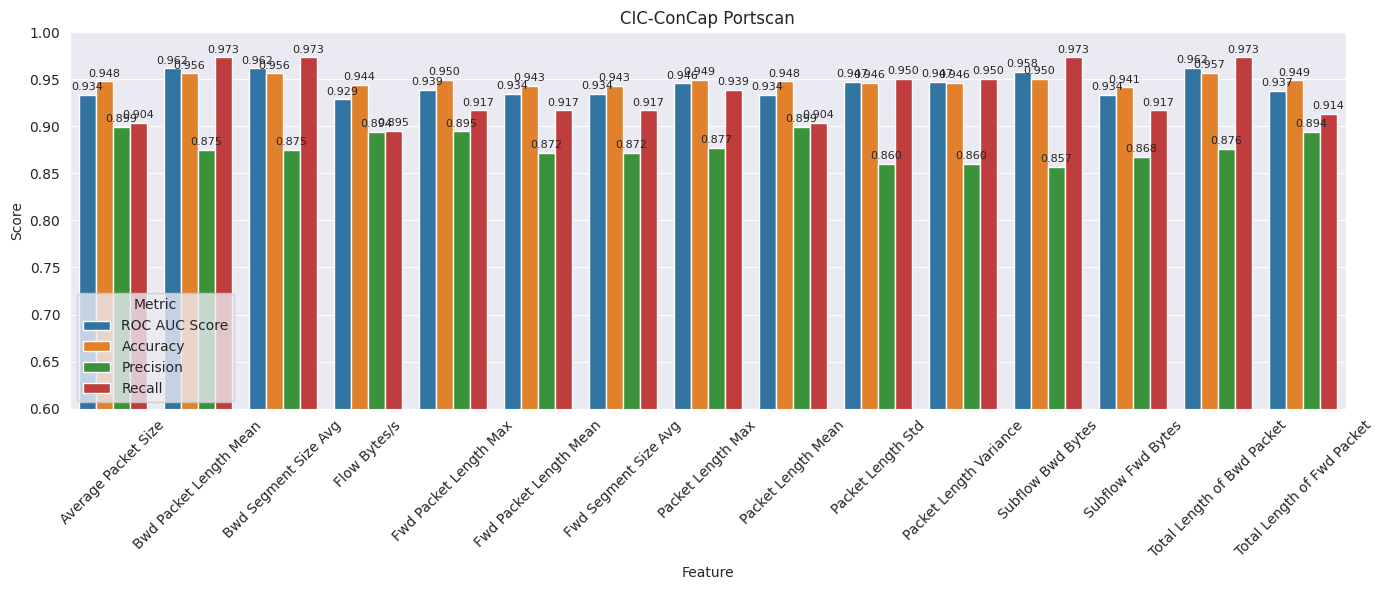

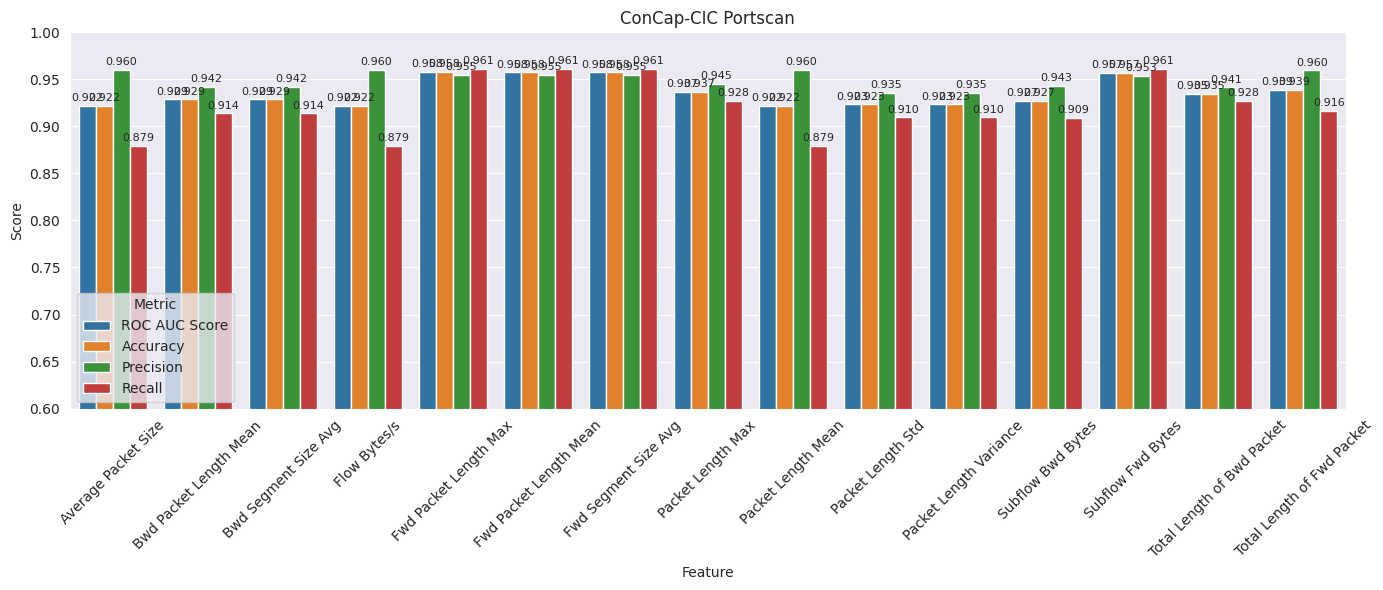

In [87]:
features = get_best_features(cic_concap, concap_cic, .92)
visualize(cic_concap, features, "CIC-ConCap Portscan", y_min=.6)
visualize(concap_cic, features, "ConCap-CIC Portscan", y_min=.6)